# 1. Importação de Bibliotecas

In [1]:
# %pip install optuna
# %pip install lightgbm
# %pip install xgboost
# %pip install feature_engine


In [2]:
# Importação das bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ctypes import alignment
import plotly.express as px


from functools import reduce
import warnings
warnings.filterwarnings("ignore")


import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# 2 Carregamento dos datasets

In [3]:
# Carregamento dos dados pelo Google Colab:
# contract_df = pd.read_csv('/content/contract.csv')
# internet_df = pd.read_csv('/content/internet.csv')
# personal_df = pd.read_csv('/content/personal.csv')
# phone_df = pd.read_csv('/content/phone.csv')

# Carregamento local:
contract_df = pd.read_csv('final_provider/contract.csv')
internet_df = pd.read_csv('final_provider/internet.csv')
personal_df = pd.read_csv('final_provider/personal.csv')
phone_df = pd.read_csv('final_provider/phone.csv')

## 2.1 Análise do dataset Contract_df

In [4]:
contract_df.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [5]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
# Correção dos tipos de dados das colunas BeginDate, EndDate e TotalCharges

contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate']).dt.date
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors = 'coerce').dt.date
contract_df['TotalCharges'] = contract_df['TotalCharges'].replace(' ', np.nan).astype('float')

In [7]:
contract_df.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

In [8]:
contract_df.duplicated().sum()

np.int64(0)

## 2.2 Análise do dataset internet_df

In [9]:
internet_df.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [10]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet_df.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [12]:
internet_df.duplicated().sum()

np.int64(0)

## 2.3 Análise do dataset personal_df

In [13]:
personal_df.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [14]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
personal_df.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [16]:
personal_df.duplicated().sum()

np.int64(0)

In [17]:
# Renomear a coluna Gender para padronização

personal_df.rename(columns={'gender': 'Gender'}, inplace=True)

## 2.4 Análise dataset phone_df

In [18]:
phone_df.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [19]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
phone_df.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [21]:
phone_df.duplicated().sum()

np.int64(0)

# 3. Préprocessamento e limpeza dos dados

## 3.1 Contract_df - Criação das colunas de Churn e duração do contrato

In [22]:
# Criação da coluna de tempo de contrato

contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
today = pd.to_datetime(pd.Timestamp.now())
contract_df['Duracao'] = contract_df['EndDate'] - contract_df['BeginDate']
contract_df['Duracao'] = contract_df['Duracao'].fillna(today - contract_df['BeginDate']).dt.days.astype(int)


In [23]:
# Criação da coluna'Churn'

contract_df['EndDate'] = contract_df['EndDate'].astype(str)
contract_df['Churn'] = contract_df['EndDate'].apply(lambda x: 'No' if x == 'NaT' else ('Yes' if pd.notnull(x) else 'No'))
contract_df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## 3.2 DataFrame Combinado (merged)

In [24]:
# Merge dos quatro datasets necessários

df = contract_df.merge(internet_df, on='customerID', how='outer') \
                        .merge(personal_df, on='customerID', how='outer') \
                        .merge(phone_df, on='customerID', how='outer')

In [25]:
# Exclusão de colunas desnecessárias

df = df.drop(['BeginDate', 'EndDate'], axis = 1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Duracao           7043 non-null   int64  
 7   Churn             7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  Gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [27]:
df.head()

customerID            Type PaperlessBilling     PaymentMethod  \
0  0002-ORFBO        One year              Yes      Mailed check   
1  0003-MKNFE  Month-to-month               No      Mailed check   
2  0004-TLHLJ  Month-to-month              Yes  Electronic check   
3  0011-IGKFF  Month-to-month              Yes  Electronic check   
4  0013-EXCHZ  Month-to-month              Yes      Mailed check   

   MonthlyCharges  TotalCharges  Duracao Churn InternetService OnlineSecurity  \
0            65.6        593.30     1994    No             DSL             No   
1            59.9        542.40     1994    No             DSL             No   
2            73.9        280.85      122   Yes     Fiber optic             No   
3            98.0       1237.85      396   Yes     Fiber optic             No   
4            83.9        267.40       91   Yes     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No         Yes         Yes              No   
1           No               No          No          No             Yes   
2           No              Yes          No          No              No   
3          Yes              Yes          No         Yes             Yes   
4           No               No         Yes         Yes              No   

   Gender  SeniorCitizen Partner Dependents MultipleLines  
0  Female              0     Yes        Yes            No  
1    Male              0      No         No           Yes  
2    Male              0      No         No            No  
3    Male              1     Yes         No            No  
4  Female              1     Yes         No            No

In [28]:
df.isna().sum()

customerID             0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Duracao                0
Churn                  0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Verifica-se que o dataframe final possui muitos valores ausentes. As colunas que que possuem dtype object devem ser preenchidas com 'No'.



In [29]:
# Preenchendo os dados faltantes das variáveis categóricas com No, visto que se estão ausentes, não são utilizadas pelos clientes.
cat_columns = df.columns[df.dtypes == 'object']
df[cat_columns] = df[cat_columns].fillna('No')

In [30]:
# Exclusão de 11 linhas com valores ausentes na coluna TotalCharges. Por se tratar de uma quantidade muito pequena em relação ao total de dados, sua excluão não trará prejuízos.
df = df.dropna()

In [31]:
# Agora o dataframe está todo preenchido e ponto para ser utilizado nas fases seguintes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Duracao           7032 non-null   int64  
 7   Churn             7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Gender            7032 non-null   object 
 16  SeniorCitizen     7032 non-null   int64  
 17  

### 3.2.1 Variáveis Categóricas

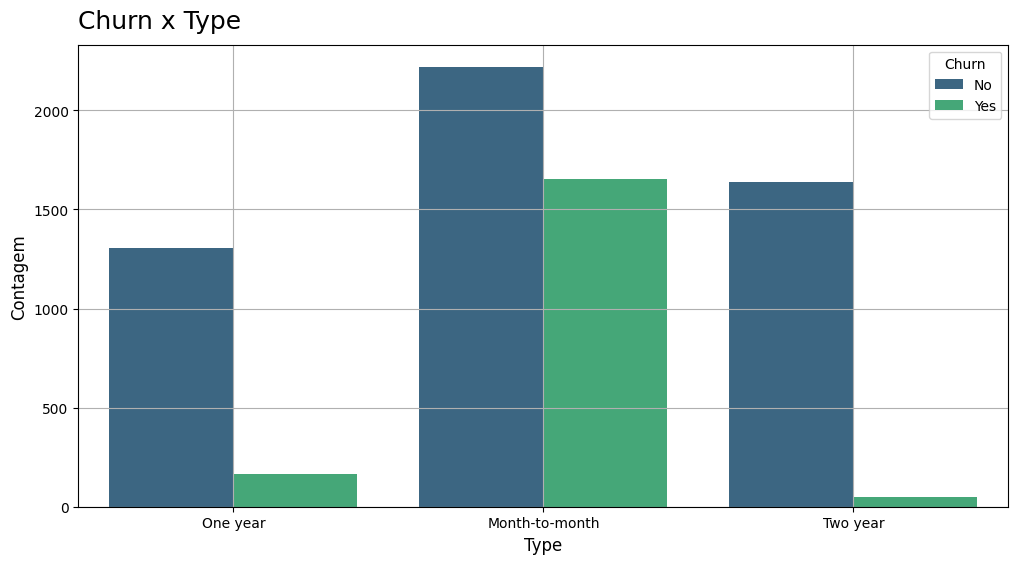

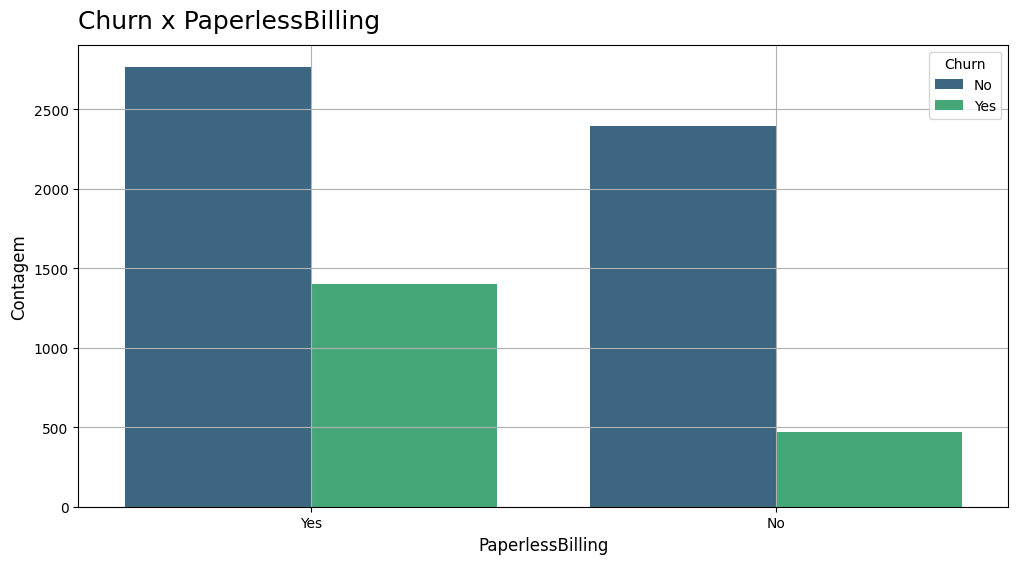

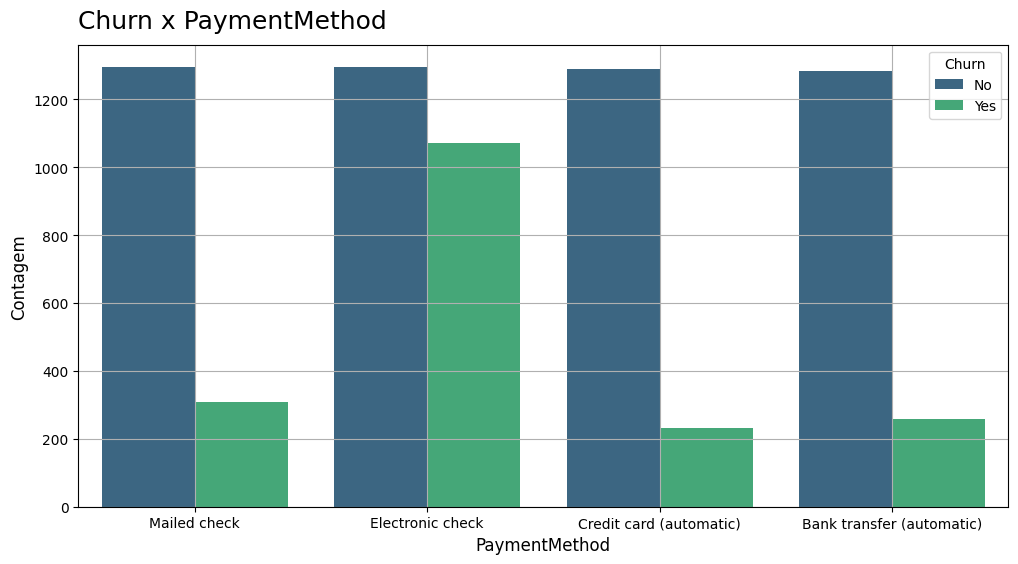

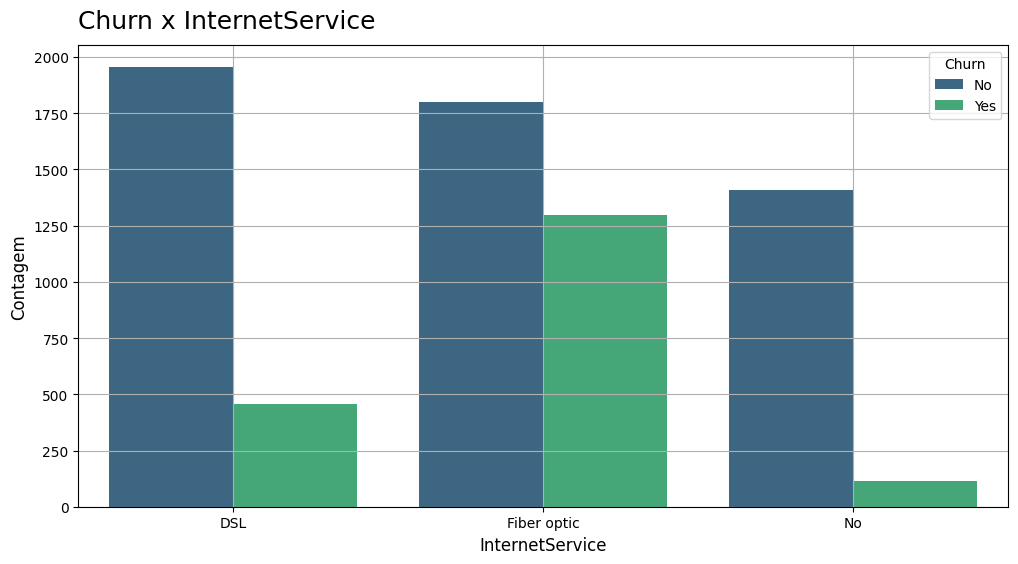

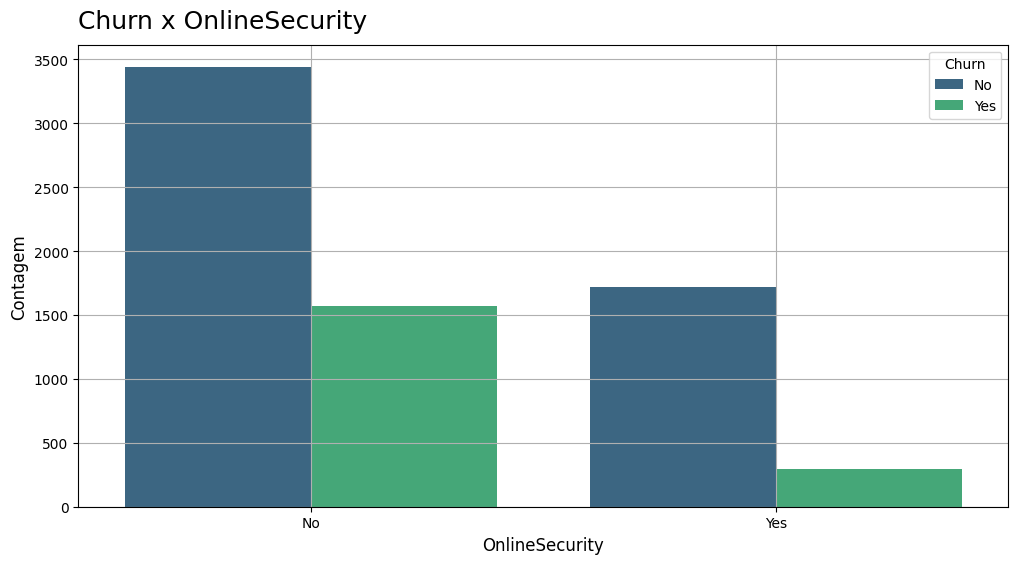

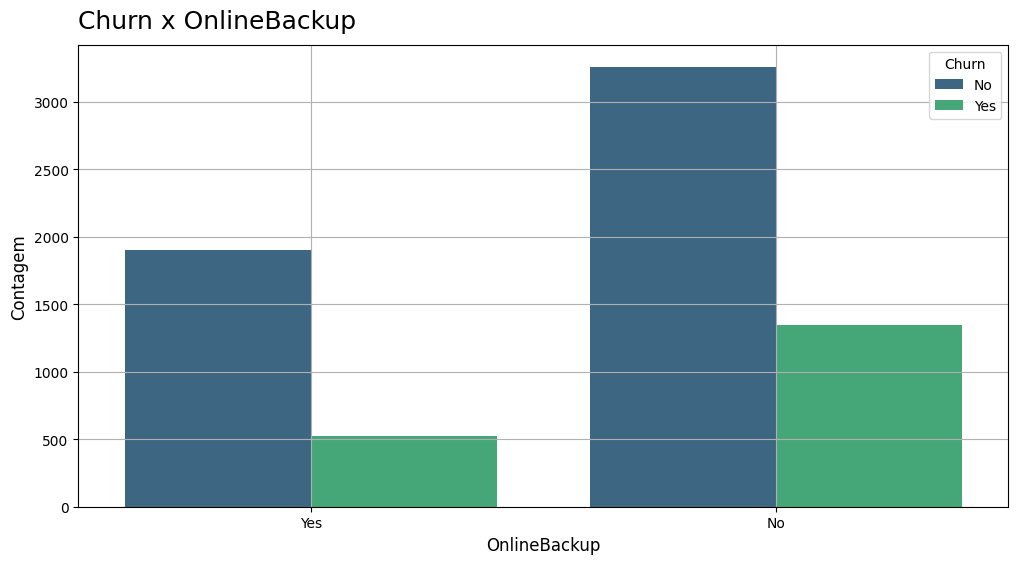

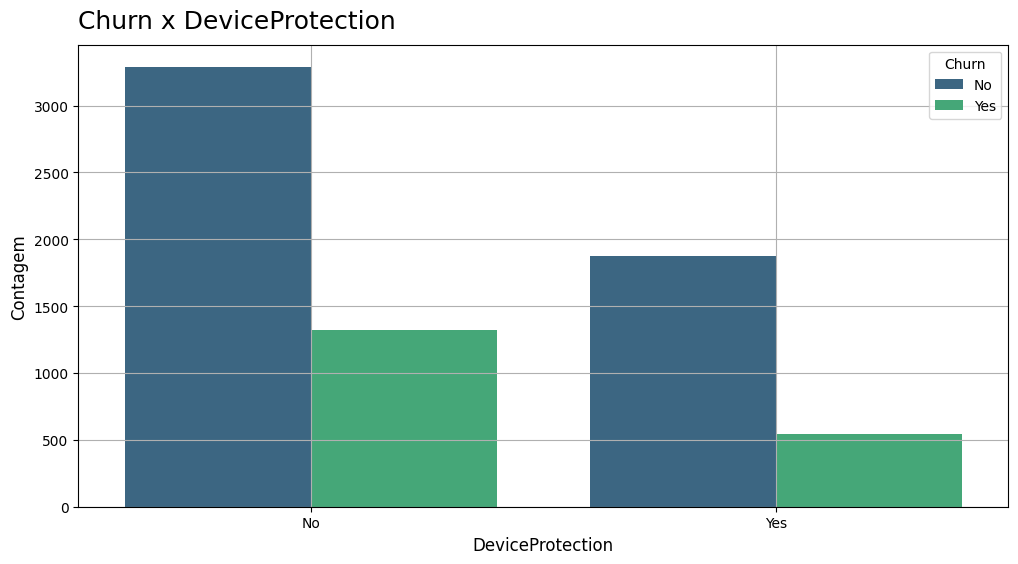

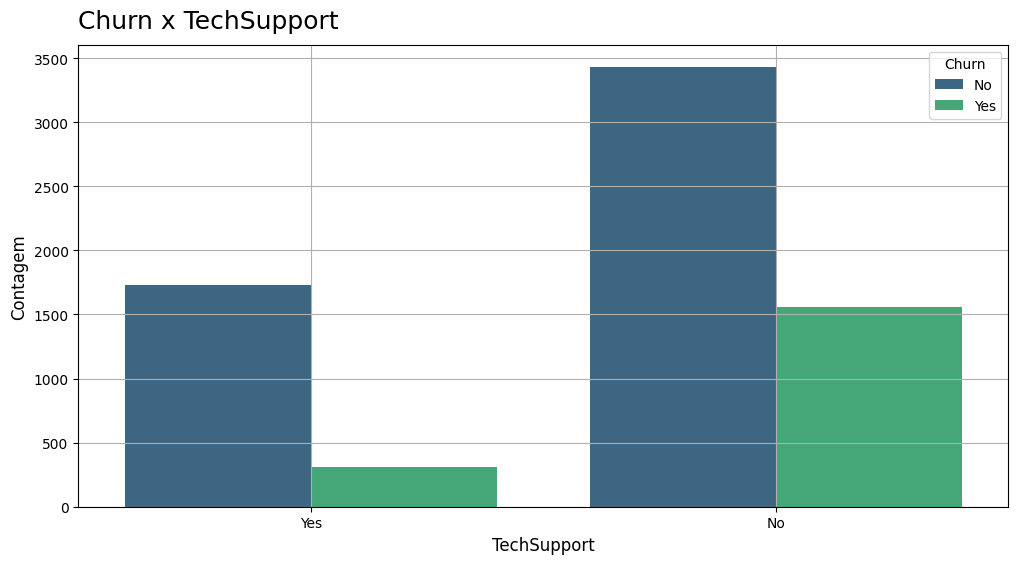

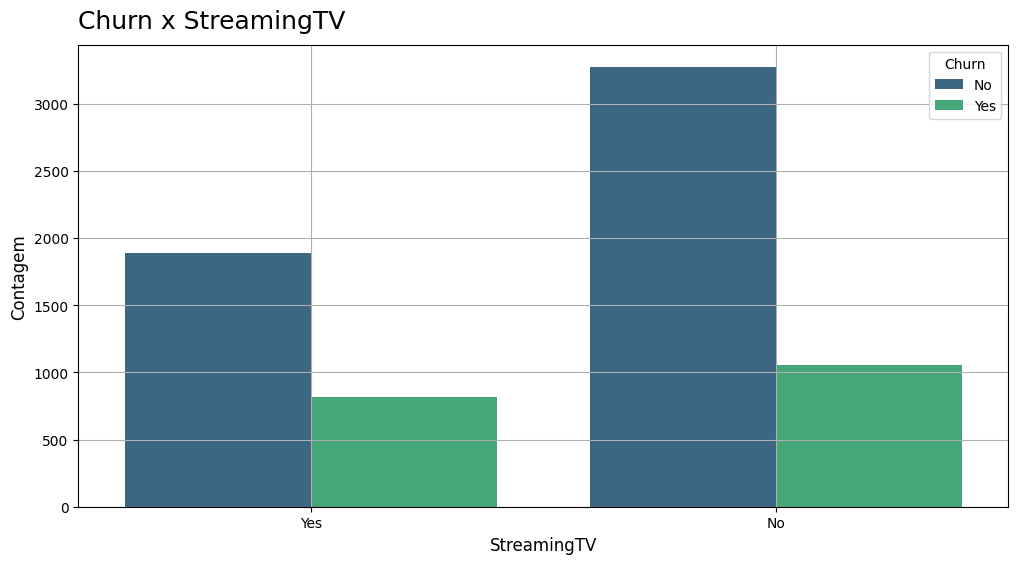

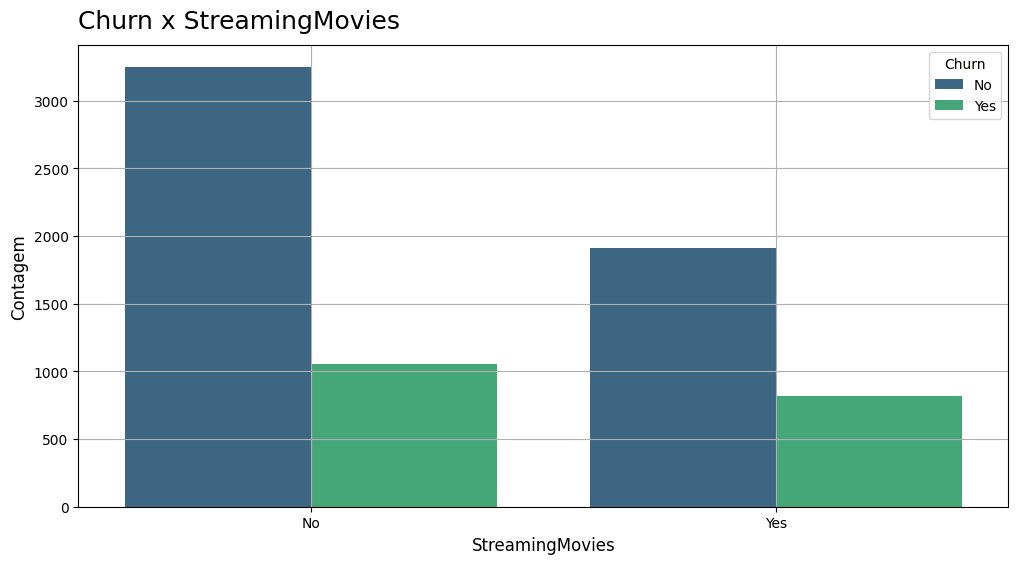

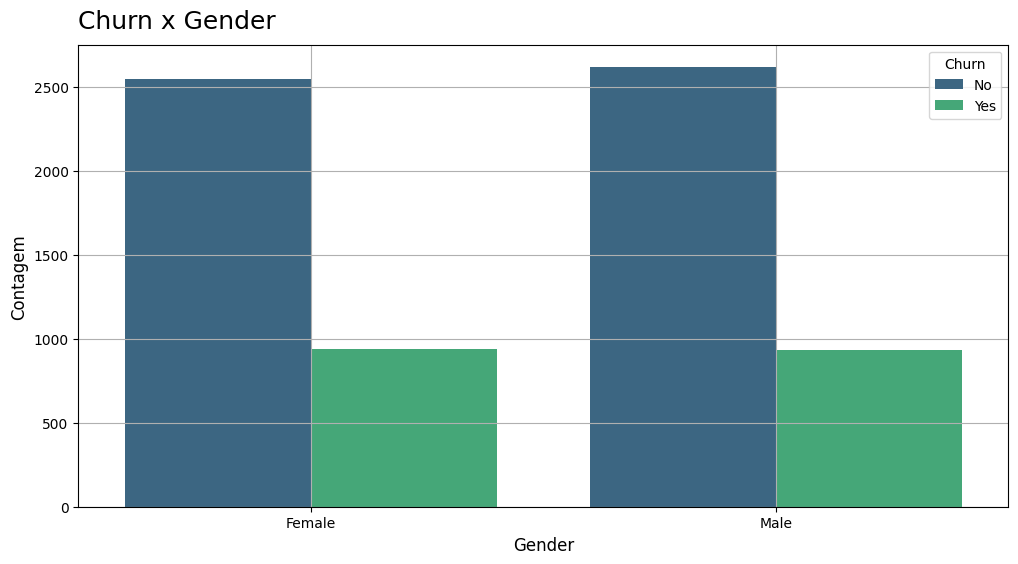

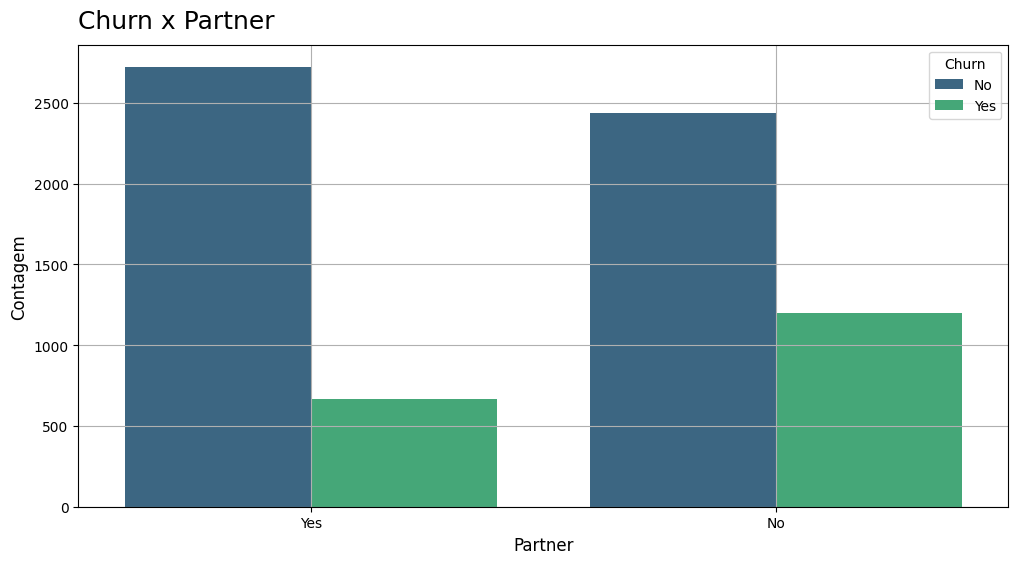

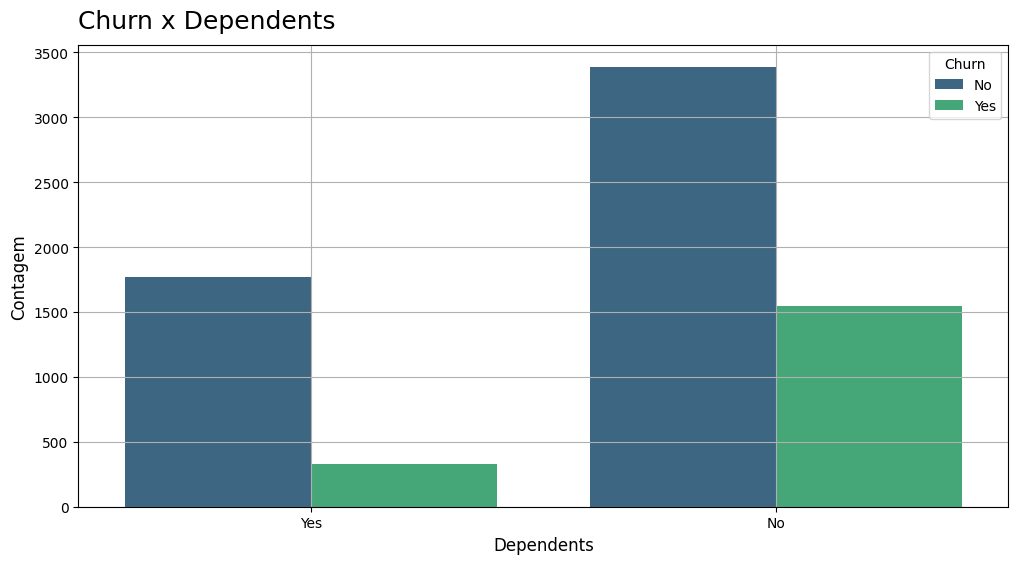

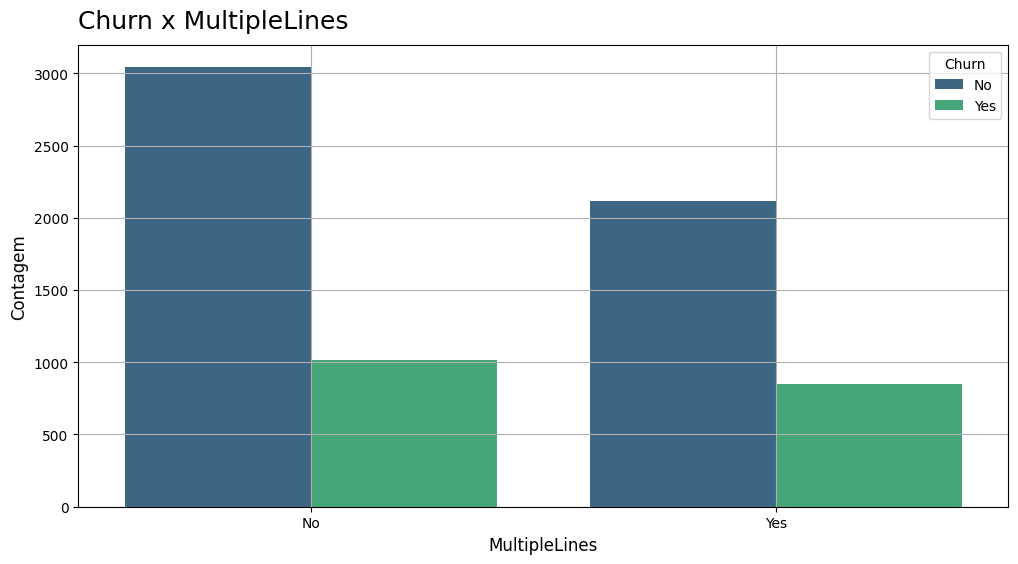

In [32]:
# Plotar gráficos confrontando o Churn com as outras variáveis

for column in df.drop(columns=['customerID', 'Churn']).columns:
    if df[column].dtype == 'object':  
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.countplot(x=column, hue='Churn', data=df, palette='viridis', ax=ax)
        
        ax.set_title(f"Churn x {column}", loc='left', fontsize=18, pad=12)
        ax.set_xlabel(column, fontsize=12)
        ax.set_ylabel("Contagem", fontsize=12)
        plt.grid(visible=True)

        plt.show()

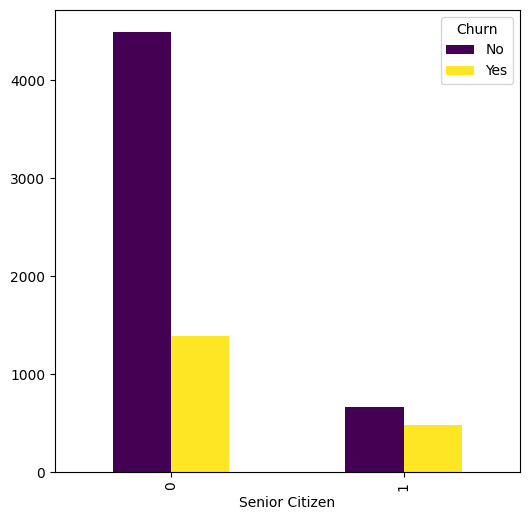

In [33]:
senior_citizen = df.groupby(['SeniorCitizen', 'Churn'])['Churn'].count().unstack()
senior_citizen.plot(kind='bar', figsize=(6,6), colormap='viridis')
plt.xlabel('Senior Citizen')
plt.show()

Analisando as variáveis categóricas, podemos concluir que:
-	Relativamente ao tipo de contrato, o que apresenta maior taxa de Churn é o de pagamento mensal. Ele é responsável quase pela integralidade dos contratos cancelados.
-	Com relação à forma e envio da conta, verifica-se que a taxa de cancelamento dos clientes Paperless é aproximadamente 3 vezes maior do que a dos clientes que optam por receber sua conta física.
-	A forma de pagamento responsável pela maior taxa de Churn é o cheque eletrônico.
-	Dentre os serviços de internet ofertados, a fibra ótica possui uma taxa de cancelamento pouco maior do que o dobro da DSL. Isso pode se dever ao fato de a fibra ótica ser acessível e comumente a primeira opção, por oferecer altas velocidades.
-	A taxa de cancelamento dos contratos de internet é maior com relação aos clientes que não utilizam os serviços ofertados pela operadora, como segurança online, backup online, proteção de dispositivos e, muito importante, o suporte. Isso pode sugerir que esses clientes não tenham conhecimento dos serviços incluídos em seus pacotes e que a não utilização do suporte para sanar dúvidas e problemas pode gerar insatisfação, levando ao cancelamento dos contratos.
-	O Churn é ligeiramente maior entre os clientes que não fazem o uso dos serviços de streaming de TV e filmes. Clientes que utilizam mais serviços disponíveis tornam-se mais fiéis à operadora.
-	O gênero não apresenta informações relevantes, uma vez que para ambos os sexos as taxas de cancelamento são similares.
-	Clientes que não possuem companheiros ou dependentes possuem taxa de cancelamento bastante superior aos que possuem dependentes, demonstrando que, muitas vezes, as decisões envolvem diversas pessoas.
-	Já o número de linhas telefônicas apresenta ligeira tendência de cancelamento para os clientes que possuem apenas uma unidade.
-	As taxas de cancelamento de contratos são mais elevadas entre a população mais jovem, sendo aproximadamente o dobro da população idosa.


## Variáveis Numéricas



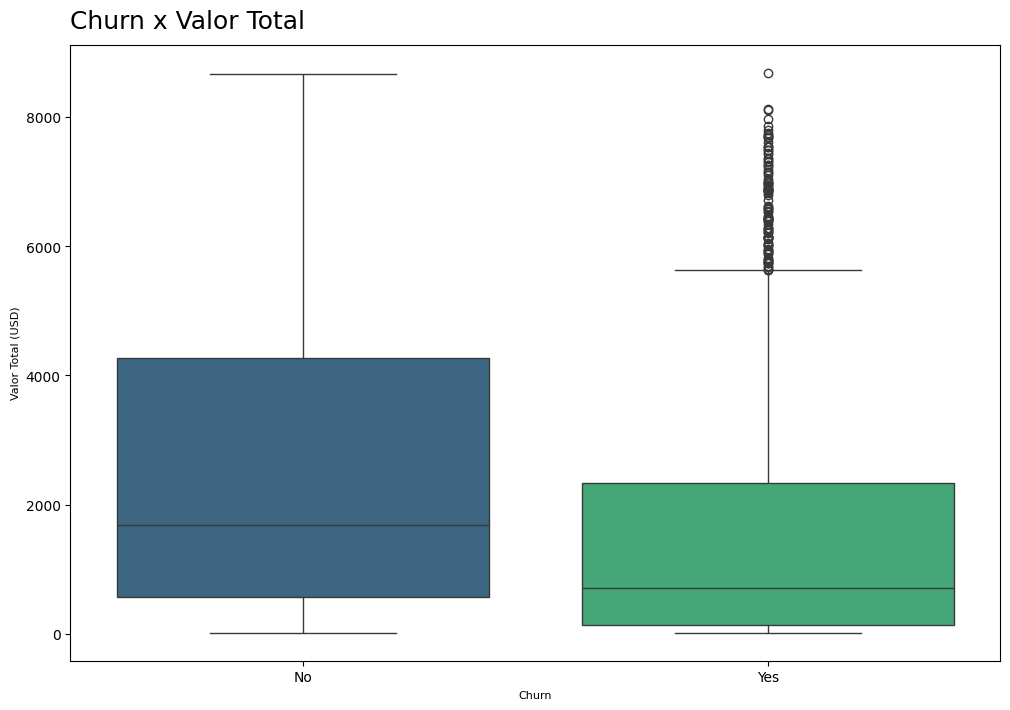

In [34]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(df, x = 'Churn', y = 'TotalCharges', palette='viridis')
ax.set_title("Churn x Valor Total", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Churn", fontsize = 8)
ax.set_ylabel("Valor Total (USD)", fontsize = 8)
plt.show()

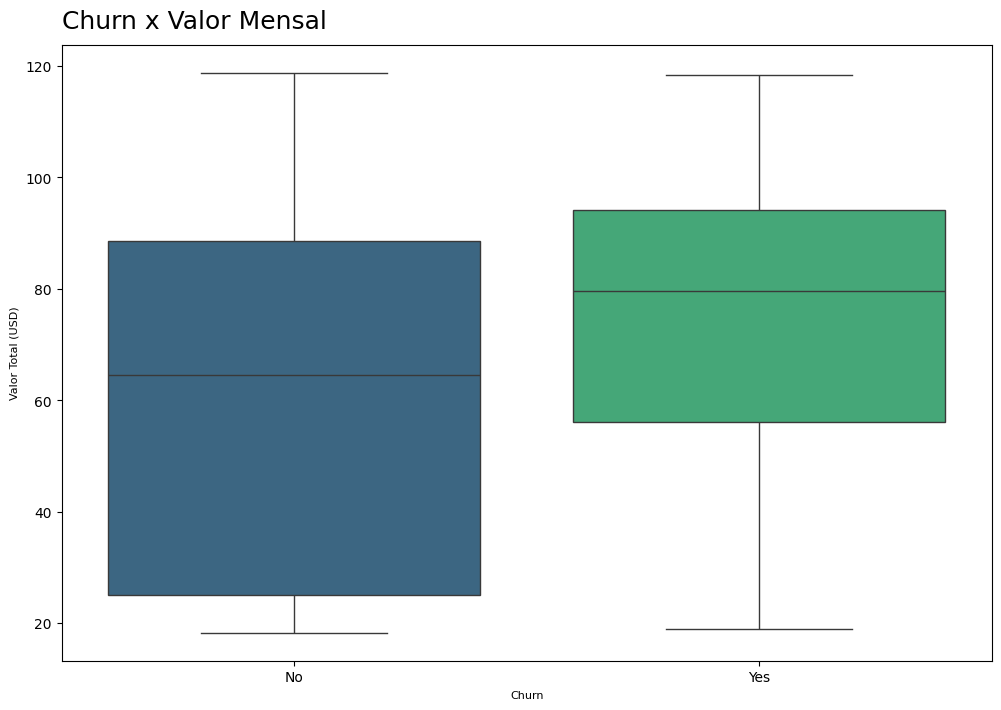

In [35]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(df, x = 'Churn', y = 'MonthlyCharges', palette='viridis')
ax.set_title("Churn x Valor Mensal", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Churn", fontsize = 8)
ax.set_ylabel("Valor Total (USD)", fontsize = 8)

plt.show()

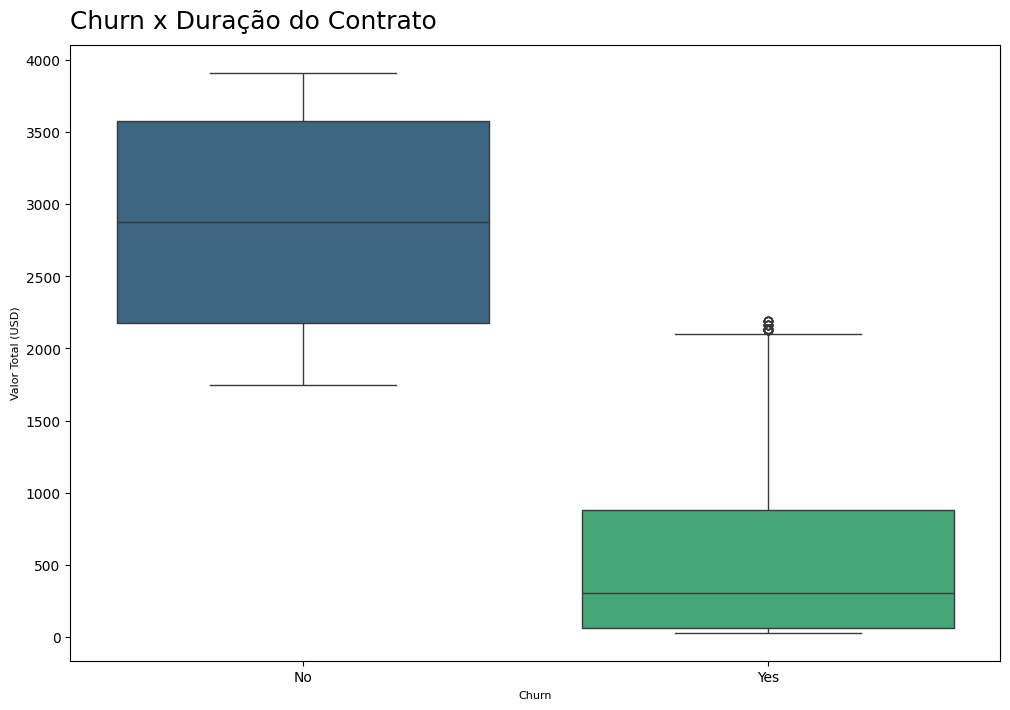

In [36]:
duration_churn = df.groupby(['Churn', 'Duracao']).size().reset_index(name='Contagem')

fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(df, x = 'Churn', y = 'Duracao', palette='viridis')
ax.set_title("Churn x Duração do Contrato", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Churn", fontsize = 8)
ax.set_ylabel("Valor Total (USD)", fontsize = 8)
plt.show()

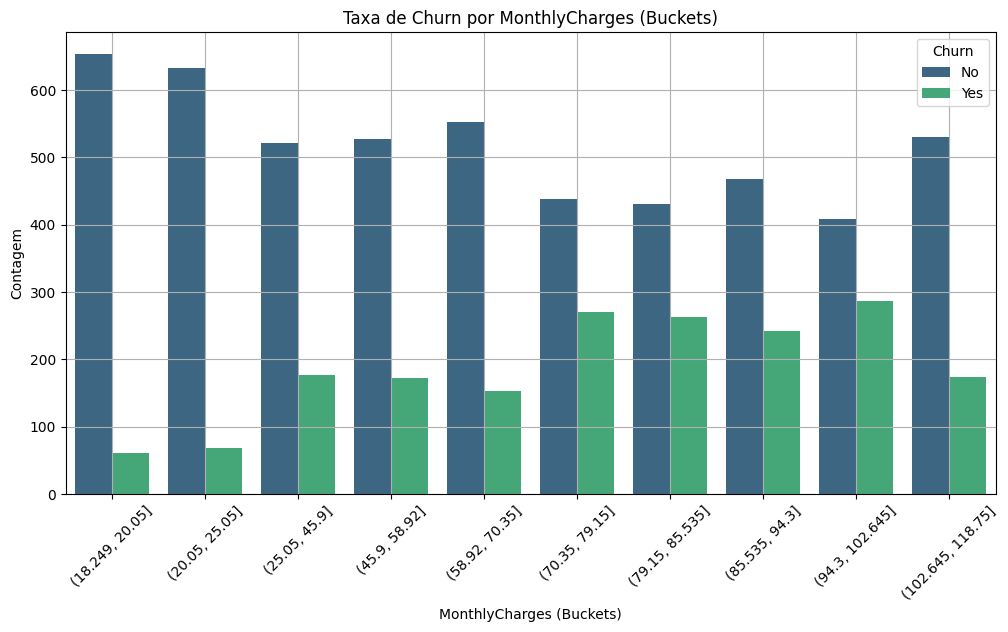

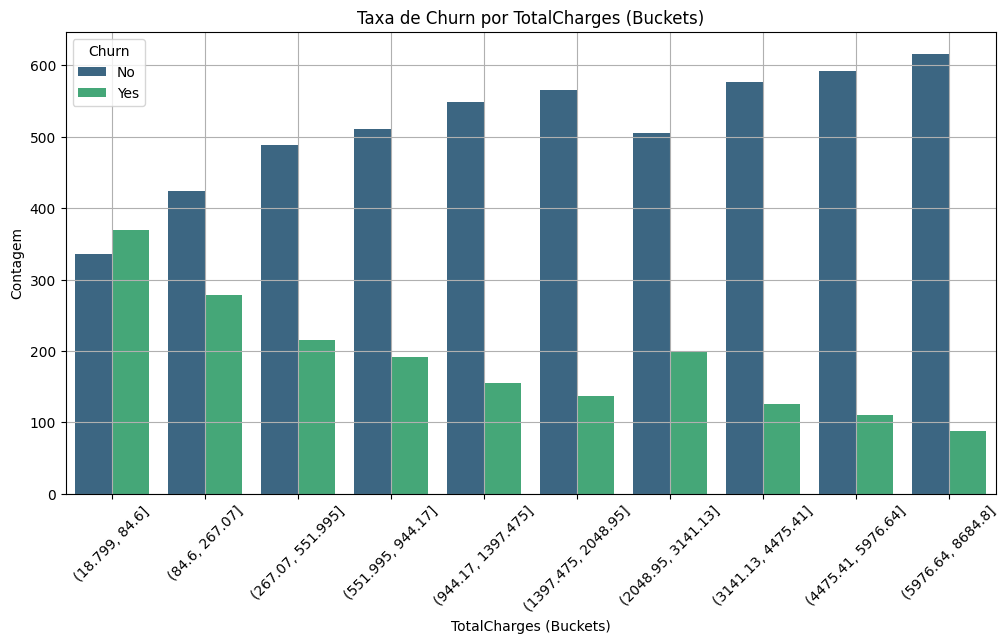

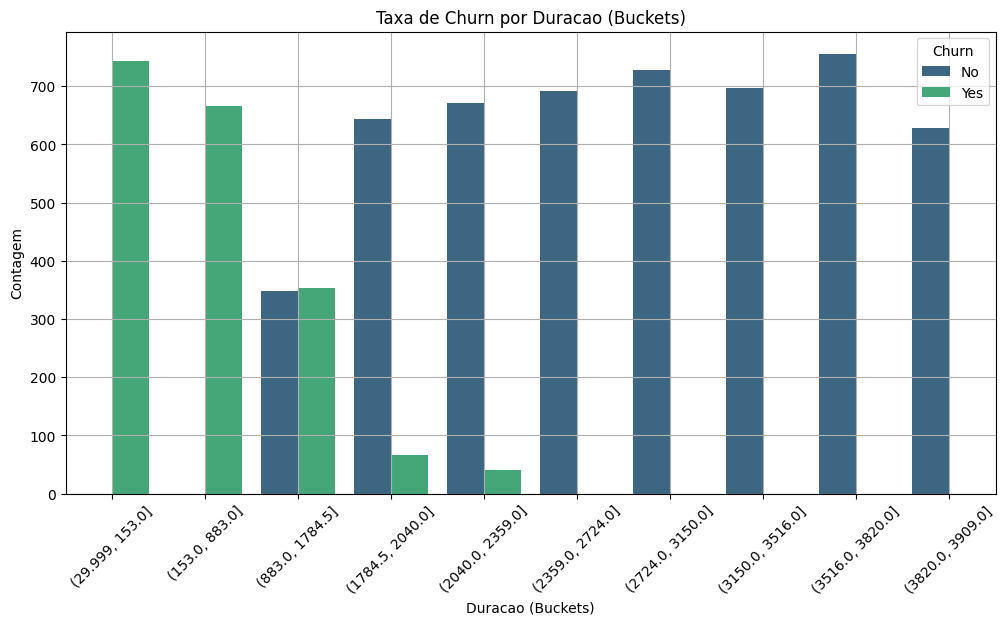

In [37]:
numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_vars.drop('SeniorCitizen'):
    df[f'{column}_bucket'] = pd.qcut(df[column], q=10)  
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x=f'{column}_bucket', hue='Churn', data=df, palette='viridis')
    plt.title(f'Taxa de Churn por {column} (Buckets)')
    plt.xlabel(f'{column} (Buckets)')
    plt.xticks(rotation=45)
    plt.ylabel('Contagem')
    plt.legend(title='Churn')
    plt.grid(visible=True)
    plt.show()

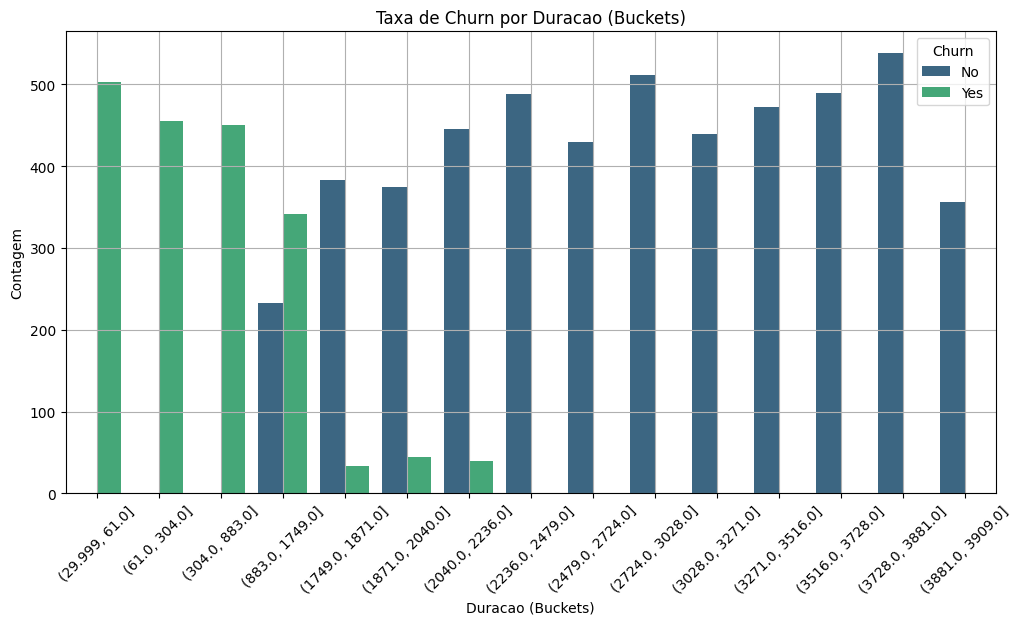

In [38]:
numerical_vars = df.select_dtypes(include=['int']).columns

for column in numerical_vars.drop('SeniorCitizen', 'Churn'):
    df[f'{column}_bucket'] = pd.qcut(df[column], q=15, duplicates='drop')  
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x=f'{column}_bucket', hue='Churn', data=df, palette='viridis')
    plt.title(f'Taxa de Churn por {column} (Buckets)')
    plt.xlabel(f'{column} (Buckets)')
    plt.xticks(rotation=45)
    plt.ylabel('Contagem')
    plt.legend(title='Churn')
    plt.grid(visible=True)
    plt.show()

Com relação às variáveis numéricas podemos verificar:
-	A média do valor mensal dos contratos cancelados gira entre 70 e 96 dólares.
-	Pelo gráfico Churn x TotalCharges, verifica-se que as taxas de cancelamento são maiores entre os contratos de menor valor. À medida que o valor dos contratos aumenta, as taxas de cancelamento diminuem, revelando clientes mais fiéis.
-	As maiores taxas de cancelamento ocorrem em contratos com duração até 883 dias, caindo para contratos até 1735 dias e, então reduzindo bastante para durações mais longas.


# Pré-processamento para utilização nos modelos de Machine Learning

In [39]:

df_final = df.copy()


In [40]:
# Exclusão de colunas que não tem relevância para os modelos

df_final = df_final.drop(columns=['customerID', 'Gender', 'Duracao_bucket', 'TotalCharges_bucket', 'MonthlyCharges_bucket', 'Duracao'], axis=1)
df_final['Churn'] = df_final['Churn'].map({'No': 0, 'Yes': 1})

In [41]:
df_final.head(10)

Type PaperlessBilling              PaymentMethod  MonthlyCharges  \
0        One year              Yes               Mailed check           65.60   
1  Month-to-month               No               Mailed check           59.90   
2  Month-to-month              Yes           Electronic check           73.90   
3  Month-to-month              Yes           Electronic check           98.00   
4  Month-to-month              Yes               Mailed check           83.90   
5  Month-to-month              Yes    Credit card (automatic)           69.40   
6        Two year              Yes  Bank transfer (automatic)          109.70   
7        Two year              Yes    Credit card (automatic)           84.65   
8  Month-to-month              Yes           Electronic check           48.20   
9        Two year              Yes               Mailed check           90.45   

   TotalCharges  Churn InternetService OnlineSecurity OnlineBackup  \
0        593.30      0             DSL             No          Yes   
1        542.40      0             DSL             No           No   
2        280.85      1     Fiber optic             No           No   
3       1237.85      1     Fiber optic             No          Yes   
4        267.40      1     Fiber optic             No           No   
5        571.45      0             DSL             No           No   
6       7904.25      0     Fiber optic            Yes          Yes   
7       5377.80      0     Fiber optic            Yes           No   
8        340.35      0             DSL            Yes           No   
9       5957.90      0             DSL            Yes          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies  SeniorCitizen  \
0               No         Yes         Yes              No              0   
1               No          No          No             Yes              0   
2              Yes          No          No              No              0   
3              Yes          No         Yes             Yes              1   
4               No         Yes         Yes              No              1   
5               No         Yes         Yes             Yes              0   
6              Yes         Yes         Yes             Yes              1   
7               No         Yes          No              No              0   
8               No          No          No              No              1   
9              Yes         Yes         Yes             Yes              0   

  Partner Dependents MultipleLines  
0     Yes        Yes            No  
1      No         No           Yes  
2      No         No            No  
3     Yes         No            No  
4     Yes         No            No  
5      No        Yes            No  
6     Yes         No            No  
7     Yes         No           Yes  
8      No         No            No  
9     Yes        Yes           Yes

In [42]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   InternetService   7032 non-null   object 
 7   OnlineSecurity    7032 non-null   object 
 8   OnlineBackup      7032 non-null   object 
 9   DeviceProtection  7032 non-null   object 
 10  TechSupport       7032 non-null   object 
 11  StreamingTV       7032 non-null   object 
 12  StreamingMovies   7032 non-null   object 
 13  SeniorCitizen     7032 non-null   int64  
 14  Partner           7032 non-null   object 
 15  Dependents        7032 non-null   object 
 16  MultipleLines     7032 non-null   object 
dtype

In [43]:
cat_features = df_final.select_dtypes(include=['object']).columns

# Selecionar colunas numéricas
num_features = df_final.select_dtypes(include=['number']).columns

print("Features Categóricas:", cat_features)
print("Features Numéricas:", num_features)

Features Categóricas: Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Partner', 'Dependents',
       'MultipleLines'],
      dtype='object')
Features Numéricas: Index(['MonthlyCharges', 'TotalCharges', 'Churn', 'SeniorCitizen'], dtype='object')


In [44]:
encoder = OrdinalEncoder()
category = df_final.columns[df_final.dtypes=='object'] 
df_final[category] = encoder.fit_transform(df_final[category])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   float64
 1   PaperlessBilling  7032 non-null   float64
 2   PaymentMethod     7032 non-null   float64
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   InternetService   7032 non-null   float64
 7   OnlineSecurity    7032 non-null   float64
 8   OnlineBackup      7032 non-null   float64
 9   DeviceProtection  7032 non-null   float64
 10  TechSupport       7032 non-null   float64
 11  StreamingTV       7032 non-null   float64
 12  StreamingMovies   7032 non-null   float64
 13  SeniorCitizen     7032 non-null   int64  
 14  Partner           7032 non-null   float64
 15  Dependents        7032 non-null   float64
 16  MultipleLines     7032 non-null   float64
dtype

In [45]:
df_final.head()


Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
0   1.0               1.0            3.0            65.6        593.30      0   
1   0.0               0.0            3.0            59.9        542.40      0   
2   0.0               1.0            2.0            73.9        280.85      1   
3   0.0               1.0            2.0            98.0       1237.85      1   
4   0.0               1.0            3.0            83.9        267.40      1   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0              0.0             0.0           1.0               0.0   
1              0.0             0.0           0.0               0.0   
2              1.0             0.0           0.0               1.0   
3              1.0             0.0           1.0               1.0   
4              1.0             0.0           0.0               0.0   

   TechSupport  StreamingTV  StreamingMovies  SeniorCitizen  Partner  \
0          1.0          1.0              0.0              0      1.0   
1          0.0          0.0              1.0              0      0.0   
2          0.0          0.0              0.0              0      0.0   
3          0.0          1.0              1.0              1      1.0   
4          1.0          1.0              0.0              1      1.0   

   Dependents  MultipleLines  
0         1.0            0.0  
1         0.0            1.0  
2         0.0            0.0  
3         0.0            0.0  
4         0.0            0.0

In [46]:
# Definindo função para avaliação dos modelos

def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for data_type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[data_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # Store the maximum F1 score and its corresponding threshold
        max_f1_score_idx = np.argmax(f1_scores)
        eval_stats[data_type]['F1 Score'] = f1_scores[max_f1_score_idx]

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps

        color = 'blue' if data_type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max F1={f1_scores[max_f1_score_idx]:.2f} @ threshold={f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score vs Threshold')

        # ROC Curve Plot
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # Precision-Recall Curve Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1 Score', 'APS', 'ROC AUC'])

    print(df_eval_stats)

    plt.tight_layout()
    plt.show()

### Pré-procesamento dos dados para utilização nos modelos

### Divisão dos dados em treino, teste e validação

In [47]:
train_data, split_data = train_test_split(df_final, test_size=0.3, random_state=12345)

In [48]:
val_data, test_data = train_test_split(split_data, test_size=0.5, random_state=12345)

In [49]:
X_train = train_data.drop(['Churn'], axis=1)
y_train = train_data['Churn']

X_val = val_data.drop(['Churn'], axis=1)
y_val = val_data['Churn']

X_test = test_data.drop(['Churn'], axis=1)
y_test = test_data['Churn']

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test: {y_test.shape}')

X_train: (4922, 16)
X_val: (1055, 16)
X_test: (1055, 16)
y_train: (4922,)
y_val: (1055,)
y_test: (1055,)


In [52]:
features = pd.concat([X_train, X_val, X_test])

cat_features = features.select_dtypes(include=['object', 'category']).columns
num_features = features.select_dtypes(include=['int64', 'float64']).columns

print("Features Categóricas:", cat_features)
print("Features Numéricas:", num_features)




Features Categóricas: Index([], dtype='object')
Features Numéricas: Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'],
      dtype='object')


In [53]:
num_transformer = Pipeline([
    ('imput', MeanMedianImputer(imputation_method='median')),
    ('scaler', MinMaxScaler())
])
cat_transformer = Pipeline([
    ('imput', CategoricalImputer(imputation_method='frequent')),
    ('ohe', OneHotEncoder())
])
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

## Random Forest Classifier

In [54]:
model = RandomForestClassifier(n_estimators=50, criterion = 'gini', class_weight='balanced')
rf = Pipeline([
('preprocessor', preprocessor),
('model', model)
])

rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index([], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50))])

In [55]:
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)


y_proba_train = rf.predict_proba(X_train)
y_proba_val = rf.predict_proba(X_val)



Métricas do RandomForestClassifier
Acurácia
Em treino: 0.9969524583502641
Em validação: 0.7772511848341233
Diferença Treino x Validação: 0.21970127351614088
---------------------------------------------
ROC AUC
Em treino: 0.9995592249229518
Em validação: 0.8108938962256271
Diferença Treino x Validação: 0.18866532869732466

          train  test
Accuracy   1.00  0.78
F1 Score   0.99  0.61
APS        1.00  0.58
ROC AUC    1.00  0.81


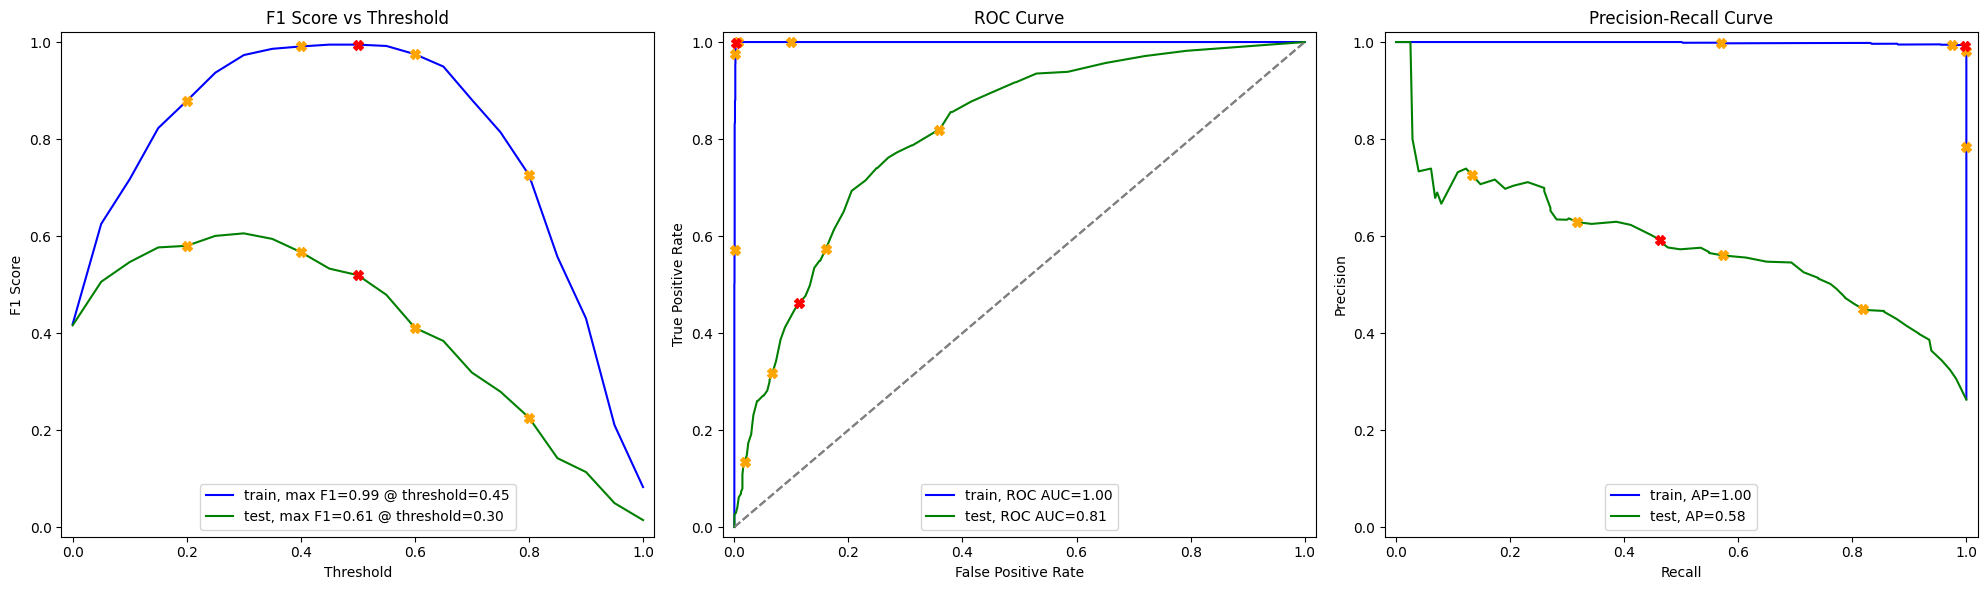

In [56]:
acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_val, y_pred_val)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
auc_val = roc_auc_score(y_val, y_proba_val[:,1])

print("Métricas do RandomForestClassifier")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em validação: {acc_val}")
print(f"Diferença Treino x Validação: {acc_train - acc_val}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em validação: {auc_val}")
print(f"Diferença Treino x Validação: {auc_train - auc_val}\n")

evaluate_model(rf, X_train, y_train, X_val, y_val)



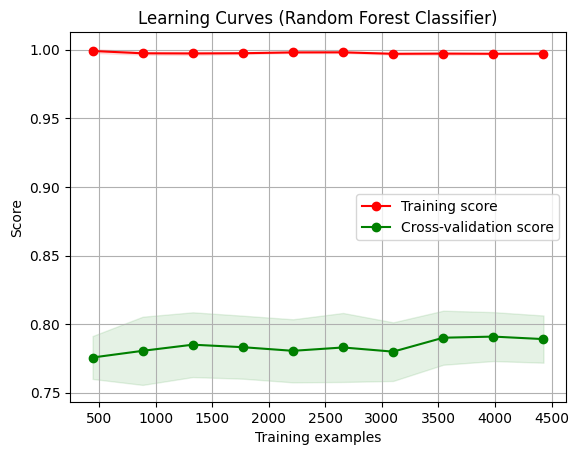

In [57]:
# Plotar Learning Curves

train_sizes, train_scores, val_scores = learning_curve(rf, X_train, y_train, cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure()
plt.title("Learning Curves (Random Forest Classifier)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.show()

### Fine tunning de hiperparâmetros com Optuna

In [61]:
def rf_finetunning(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  
        'max_depth': trial.suggest_int('max_depth', 2, 20),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),  # Número de recursos a serem considerados para a melhor divisão
        'random_state': 12345,
    }

    model = RandomForestClassifier(**params)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc

rf_study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize', sampler=TPESampler())
rf_study.optimize(rf_finetunning, n_trials=100, n_jobs=-1)

best_params = rf_study.best_params

print("Melhores hiperparâmetros: ", rf_study.best_params)
print("Melhor ROC AUC: ", rf_study.best_value)

optuna.visualization.plot_optimization_history(rf_study)
optuna.visualization.plot_param_importances(rf_study)

[I 2024-10-15 14:26:58,266] A new study created in memory with name: RandomForestClassifier
[I 2024-10-15 14:27:00,931] Trial 2 finished with value: 0.8554007777045651 and parameters: {'n_estimators': 54, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8554007777045651.
[I 2024-10-15 14:27:01,462] Trial 0 finished with value: 0.8453105713994041 and parameters: {'n_estimators': 62, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8554007777045651.
[I 2024-10-15 14:27:02,808] Trial 6 finished with value: 0.8517210657707905 and parameters: {'n_estimators': 109, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8554007777045651.
[I 2024-10-15 14:27:02,993] Trial 7 finished with value: 0.8559228049335054 and parameters: {'n_estimators': 116, 'max_depth': 4, 'min_samples_split': 8, 'min_

Melhores hiperparâmetros:  {'n_estimators': 295, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'entropy'}
Melhor ROC AUC:  0.8580758772377568


### Verificação final com melhores hiperparâmetros

Métricas do RandomForestClassifier
Acurácia
Em treino: 0.9969524583502641
Em Teste: 0.7914691943127962
Diferença Treino x Teste: 0.20548326403746797
---------------------------------------------
ROC AUC
Em treino: 0.9995592249229518
Em Teste: 0.8528598661089377
Diferença Treino x Teste: 0.14669935881401408

          train  test
Accuracy   0.79  0.79
F1 Score   0.63  0.64
APS        0.66  0.68
ROC AUC    0.85  0.85


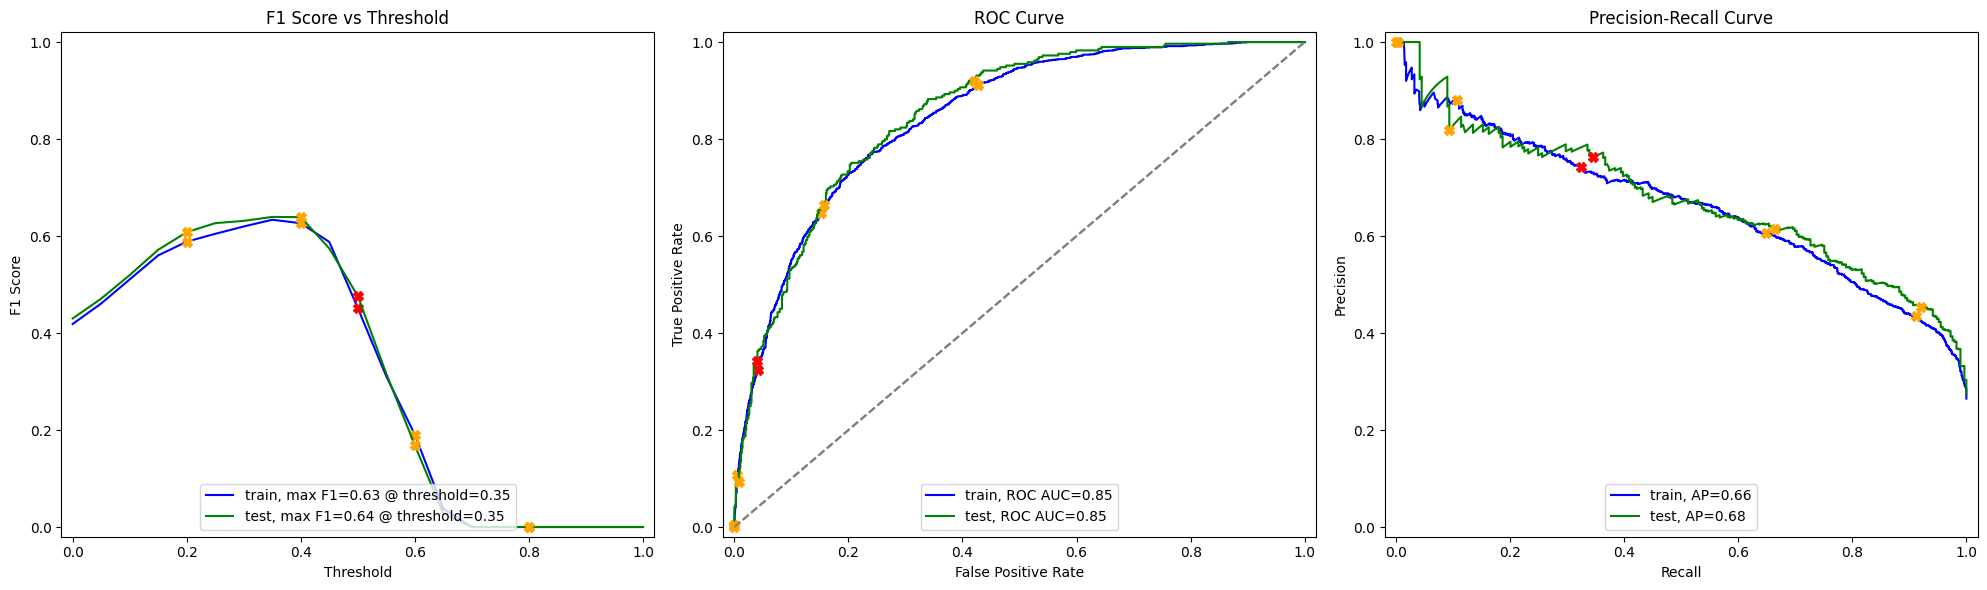

In [62]:


rf_final = RandomForestClassifier(**best_params, random_state=12345)
rf_final.fit(X_train, y_train)

y_pred_test = rf_final.predict(X_test)
y_proba_test = rf_final.predict_proba(X_test)


acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
rf_auc_test = roc_auc_score(y_test, y_proba_test[:,1])

print("Métricas do RandomForestClassifier")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em Teste: {acc_test}")
print(f"Diferença Treino x Teste: {acc_train - acc_test}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em Teste: {rf_auc_test}")
print(f"Diferença Treino x Teste: {auc_train - rf_auc_test}\n")

evaluate_model(rf_final, X_train, y_train, X_test, y_test)



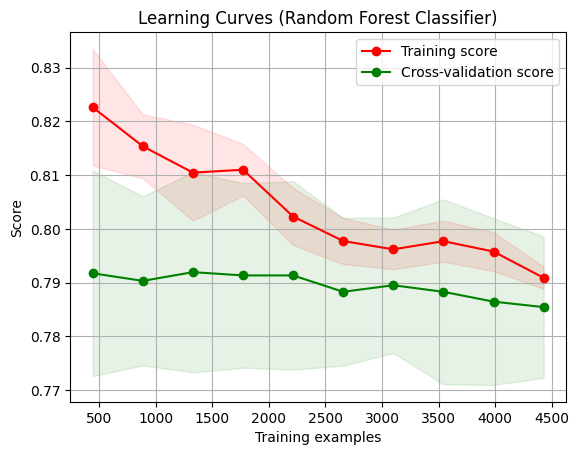

In [63]:
train_sizes, train_scores, test_scores = learning_curve(rf_final, X_train, y_train, cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves (Random Forest Classifier)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.show()

## Support Vector Classifier

In [64]:
svc = SVC(random_state=42, probability=True, class_weight=None, kernel='sigmoid', C=1, gamma='auto', )
svc = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index([], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50))])

Métricas do SuportVectorMachine
Acurácia
Em treino: 0.9969524583502641
Em validação: 0.776303317535545
Diferença Treino x Validação: 0.2206491408147191
---------------------------------------------
ROC AUC
Em treino: 0.9996021678881201
Em validação: 0.8128172765491447
Diferença Treino x Validação: 0.18678489133897536

          train  test
Accuracy   1.00  0.78
F1 Score   0.99  0.60
APS        1.00  0.59
ROC AUC    1.00  0.81


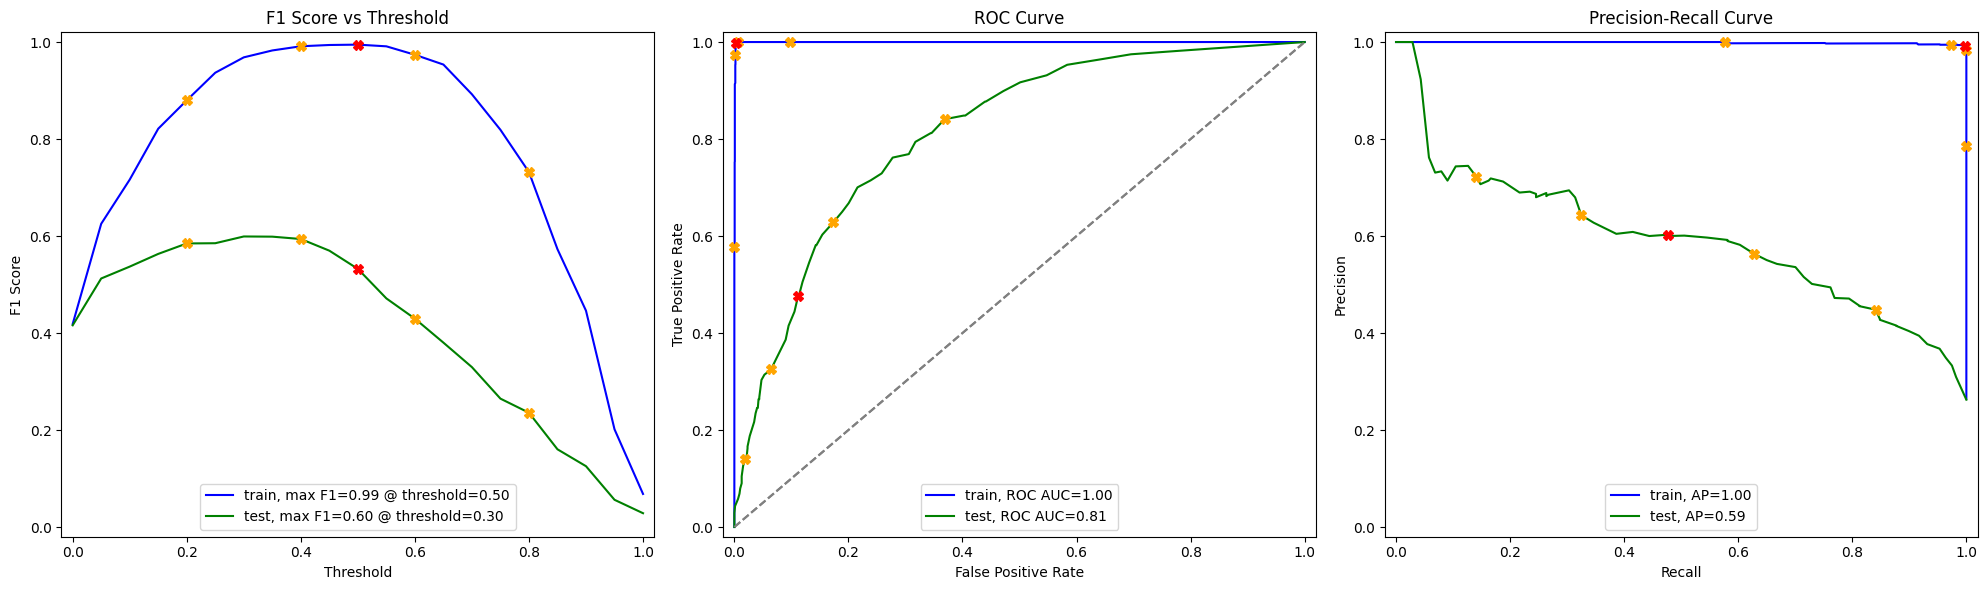

In [65]:
y_pred_train = svc.predict(X_train)
y_pred_val = svc.predict(X_val)

y_proba_train = svc.predict_proba(X_train)
y_proba_val = svc.predict_proba(X_val)

acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_val, y_pred_val)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
auc_val = roc_auc_score(y_val, y_proba_val[:,1])

print("Métricas do SuportVectorMachine")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em validação: {acc_val}")
print(f"Diferença Treino x Validação: {acc_train - acc_val}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em validação: {auc_val}")
print(f"Diferença Treino x Validação: {auc_train - auc_val}\n")

evaluate_model(svc, X_train, y_train, X_val, y_val)


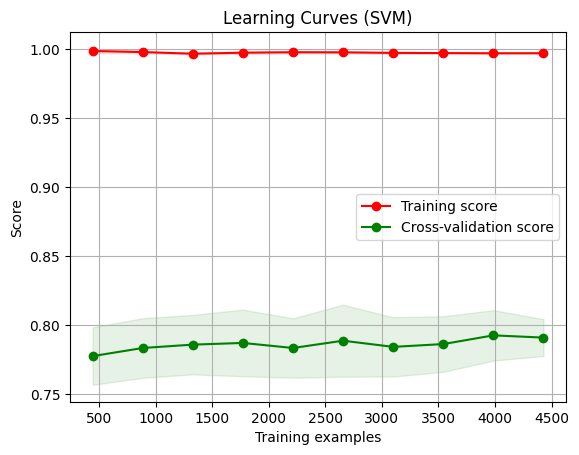

In [68]:
# Plotar Learning Curves

train_sizes, train_scores, val_scores = learning_curve(svc, X_train, y_train, cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure()
plt.title("Learning Curves (SVM)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.show()

In [69]:
def scv_finetunning(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.00001, 1.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'probability': True,
        'random_state': 12345
        
    }
    
    model = SVC(**params)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc

svc_study = optuna.create_study(study_name='SuportVectorMachine', direction='maximize')
svc_study.optimize(scv_finetunning, n_trials=70, n_jobs=-1)

print("Melhores hiperparâmetros: ", svc_study.best_params)
print("Melhor ROC AUC: ", svc_study.best_value)

best_params = svc_study.best_params

optuna.visualization.plot_optimization_history(svc_study)
optuna.visualization.plot_param_importances(svc_study)

[I 2024-10-15 14:29:27,170] A new study created in memory with name: SuportVectorMachine
[I 2024-10-15 14:29:32,165] Trial 0 finished with value: 0.8422062494779727 and parameters: {'C': 0.02200651879032472, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8422062494779727.
[I 2024-10-15 14:29:32,239] Trial 2 finished with value: 0.8386332631110038 and parameters: {'C': 0.00013180239981307515, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8422062494779727.
[I 2024-10-15 14:29:32,450] Trial 4 finished with value: 0.8374360806659674 and parameters: {'C': 0.36156401624289464, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8422062494779727.
[I 2024-10-15 14:29:34,927] Trial 5 finished with value: 0.8408396981986581 and parameters: {'C': 0.00014694502898692185, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.8422062494779727.
[I 2024-10-15 14:29:35,441] Trial 1 finished with value: 0.8256081037186898 and param

Melhores hiperparâmetros:  {'C': 0.053097893221685406, 'kernel': 'linear', 'gamma': 'scale'}
Melhor ROC AUC:  0.8439324195150018


Métricas do SuportVectorMachine
Acurácia
Em treino: 0.9969524583502641
Em Teste: 0.7971563981042654
Diferença Treino x Teste: 0.19979606024599872
---------------------------------------------
ROC AUC
Em treino: 0.9996021678881201
Em Teste: 0.8329591550949976
Diferença Treino x Teste: 0.16664301279312244

          train  test
Accuracy   0.79  0.80
F1 Score   0.61  0.64
APS        0.62  0.65
ROC AUC    0.81  0.83


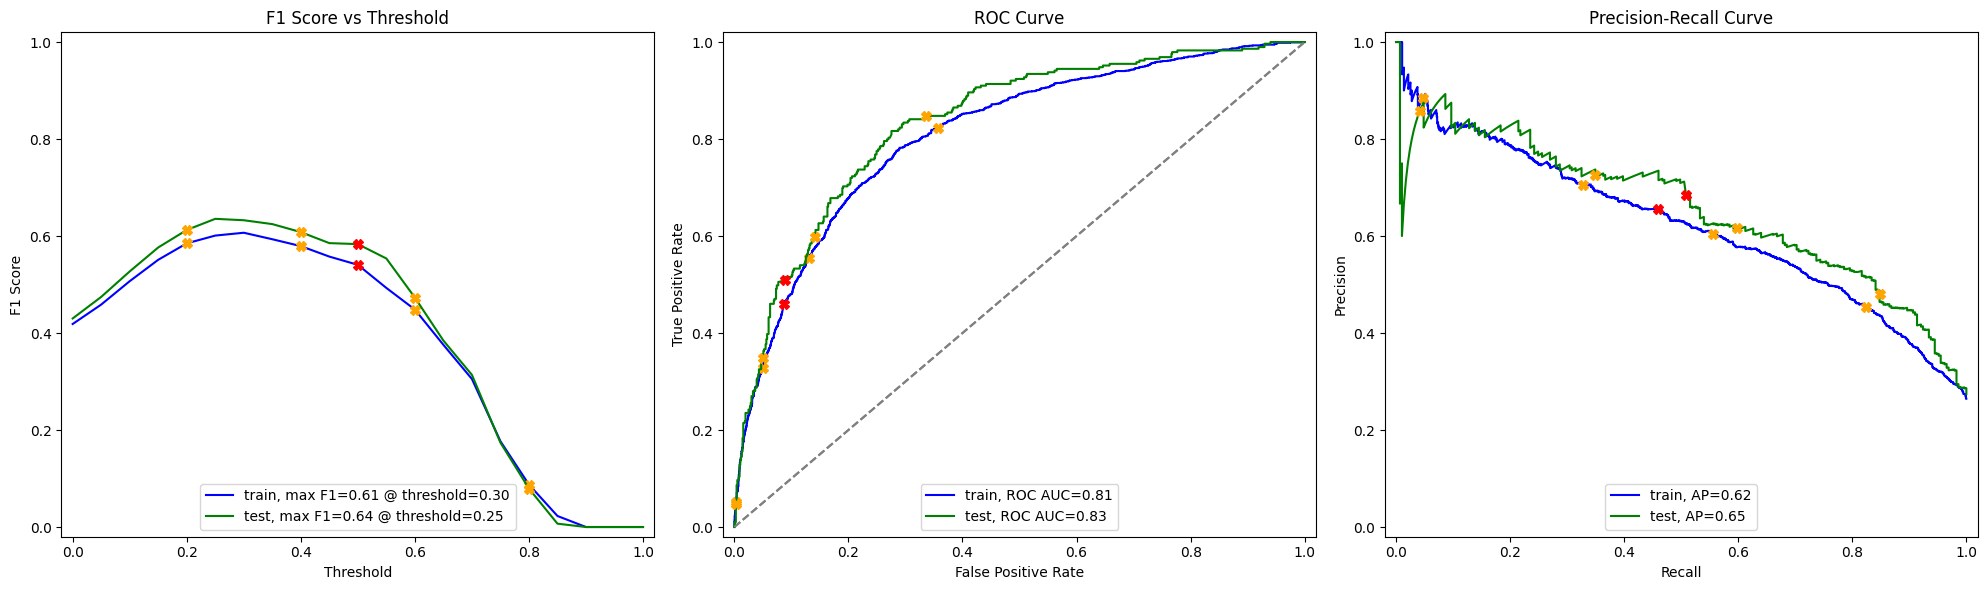

In [70]:
best_svc = SVC(**best_params, random_state=12345, probability=True)
best_svc.fit(X_train, y_train)

y_pred_test = best_svc.predict(X_test)
y_proba_test = best_svc.predict_proba(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
svc_auc_test = roc_auc_score(y_test, y_proba_test[:,1])

print("Métricas do SuportVectorMachine")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em Teste: {acc_test}")
print(f"Diferença Treino x Teste: {acc_train - acc_test}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em Teste: {svc_auc_test}")
print(f"Diferença Treino x Teste: {auc_train - svc_auc_test}\n")

evaluate_model(best_svc, X_train, y_train, X_test, y_test)


## Logistic Regression

In [73]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
lr = Pipeline([
('preprocessor', preprocessor),
('model', lr)
])

lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Métricas do LogisticRegression
Acurácia
Em treino: 0.732222673709874
Em validação: 0.7469194312796209
Diferença Treino x Validação: -0.014696757569746866
---------------------------------------------
ROC AUC
Em treino: 0.8273988629551079
Em validação: 0.8532732267315063
Diferença Treino x Validação: -0.0258743637763984

          train  test
Accuracy   0.73  0.75
F1 Score   0.61  0.64
APS        0.62  0.65
ROC AUC    0.83  0.85


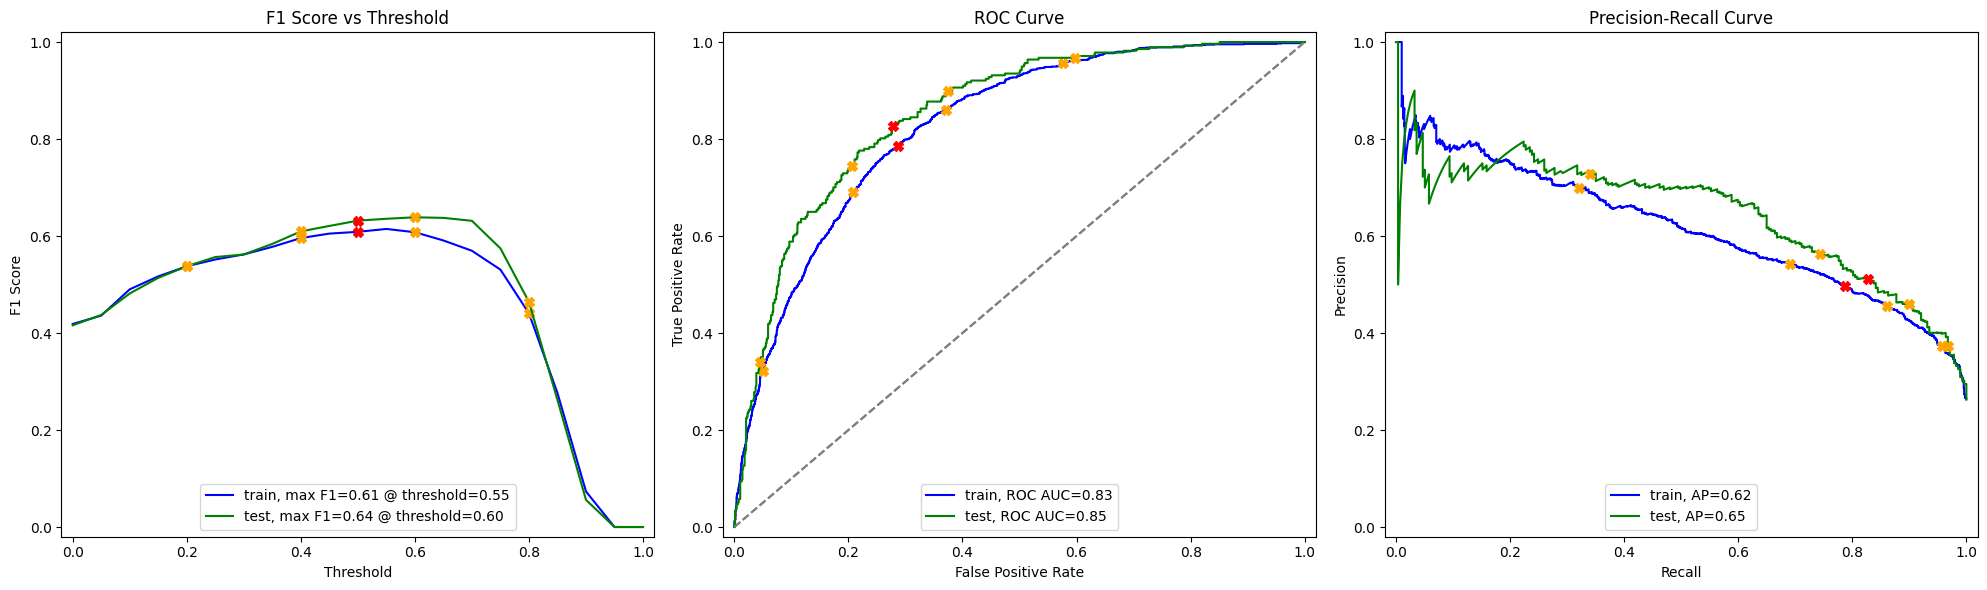

In [74]:
y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

y_proba_train = lr.predict_proba(X_train)
y_proba_val = lr.predict_proba(X_val)

acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_val, y_pred_val)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
auc_val = roc_auc_score(y_val, y_proba_val[:,1])

print("Métricas do LogisticRegression")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em validação: {acc_val}")
print(f"Diferença Treino x Validação: {acc_train - acc_val}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em validação: {auc_val}")
print(f"Diferença Treino x Validação: {auc_train - auc_val}\n")

evaluate_model(lr, X_train, y_train, X_val, y_val)


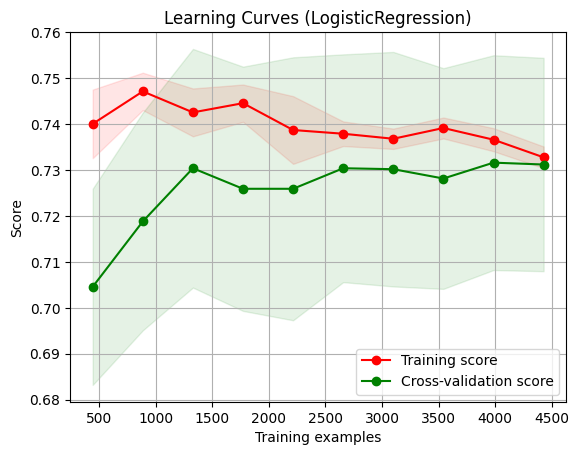

In [77]:
# Plotar Learning Curves

train_sizes, train_scores, val_scores = learning_curve(lr, X_train, y_train, cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure()
plt.title("Learning Curves (LogisticRegression)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.show()

### Fine tunning de hiperparâmetros com Optuna

In [80]:
def lr_objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-15, 1e5),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None]),
        'tol': trial.suggest_loguniform('tol', 1e-10, 1e-2),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'random_state': 12345
    }
    
    if params['solver'] == 'liblinear':
        params['penalty'] = 'l1' if params['penalty'] in ['l1', 'elasticnet'] else 'l2'
    elif params['solver'] in ['newton-cg', 'lbfgs', 'sag']:
        params['penalty'] = 'l2'
    elif params['solver'] == 'saga':
        if params['penalty'] not in ['l1', 'l2', 'elasticnet', None]:
            params['penalty'] = 'l2'
    else:
        raise ValueError(f"Unknown solver: {params['solver']}")
    
    if params['penalty'] != 'elasticnet':
        params.pop('l1_ratio')
    
    model = LogisticRegression(**params)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

lr_study = optuna.create_study(study_name='LogisticRegression', direction='maximize', sampler=TPESampler())
lr_study.optimize(lr_objective, n_trials=100, n_jobs=-1)

# Resultados da otimização
print("Melhores hiperparâmetros: ", lr_study.best_params)
print("Melhor ROC AUC: ", lr_study.best_value)

best_params = lr_study.best_params

optuna.visualization.plot_optimization_history(lr_study)
optuna.visualization.plot_param_importances(lr_study)

[I 2024-10-15 14:42:02,366] A new study created in memory with name: LogisticRegression
[I 2024-10-15 14:42:02,809] Trial 0 finished with value: 0.8530272939036501 and parameters: {'C': 115.43418279388199, 'max_iter': 957, 'solver': 'liblinear', 'penalty': None, 'tol': 0.004621213147952962, 'class_weight': 'balanced', 'l1_ratio': 0.9335585532106022}. Best is trial 0 with value: 0.8530272939036501.
[I 2024-10-15 14:42:03,025] Trial 3 finished with value: 0.8213530017725724 and parameters: {'C': 5.693816008874351e-07, 'max_iter': 522, 'solver': 'sag', 'penalty': 'l1', 'tol': 4.39810141415712e-07, 'class_weight': 'balanced', 'l1_ratio': 0.9533380307386748}. Best is trial 0 with value: 0.8530272939036501.
[I 2024-10-15 14:42:03,034] Trial 7 finished with value: 0.82134604140952 and parameters: {'C': 3.004125101147153e-14, 'max_iter': 545, 'solver': 'sag', 'penalty': 'l1', 'tol': 4.740707868600525e-09, 'class_weight': 'balanced', 'l1_ratio': 0.6702378695599241}. Best is trial 0 with value: 

Melhores hiperparâmetros:  {'C': 0.44821597756324505, 'max_iter': 277, 'solver': 'saga', 'penalty': 'l2', 'tol': 0.0005072096849873087, 'class_weight': 'balanced', 'l1_ratio': 0.25591448105933307}
Melhor ROC AUC:  0.8535098790752926


Métricas do LogisticRegression
Acurácia
Em treino: 0.732222673709874
Em teste: 0.5933649289099526
Diferença Treino x Teste: 0.1388577447999214
---------------------------------------------
ROC AUC
Em treino: 0.8273988629551079
Em teste: 0.7838499552793011
Diferença Treino x Teste: 0.04354890767580677

          train  test
Accuracy   0.58  0.59
F1 Score   0.57  0.59
APS        0.58  0.60
ROC AUC    0.76  0.78


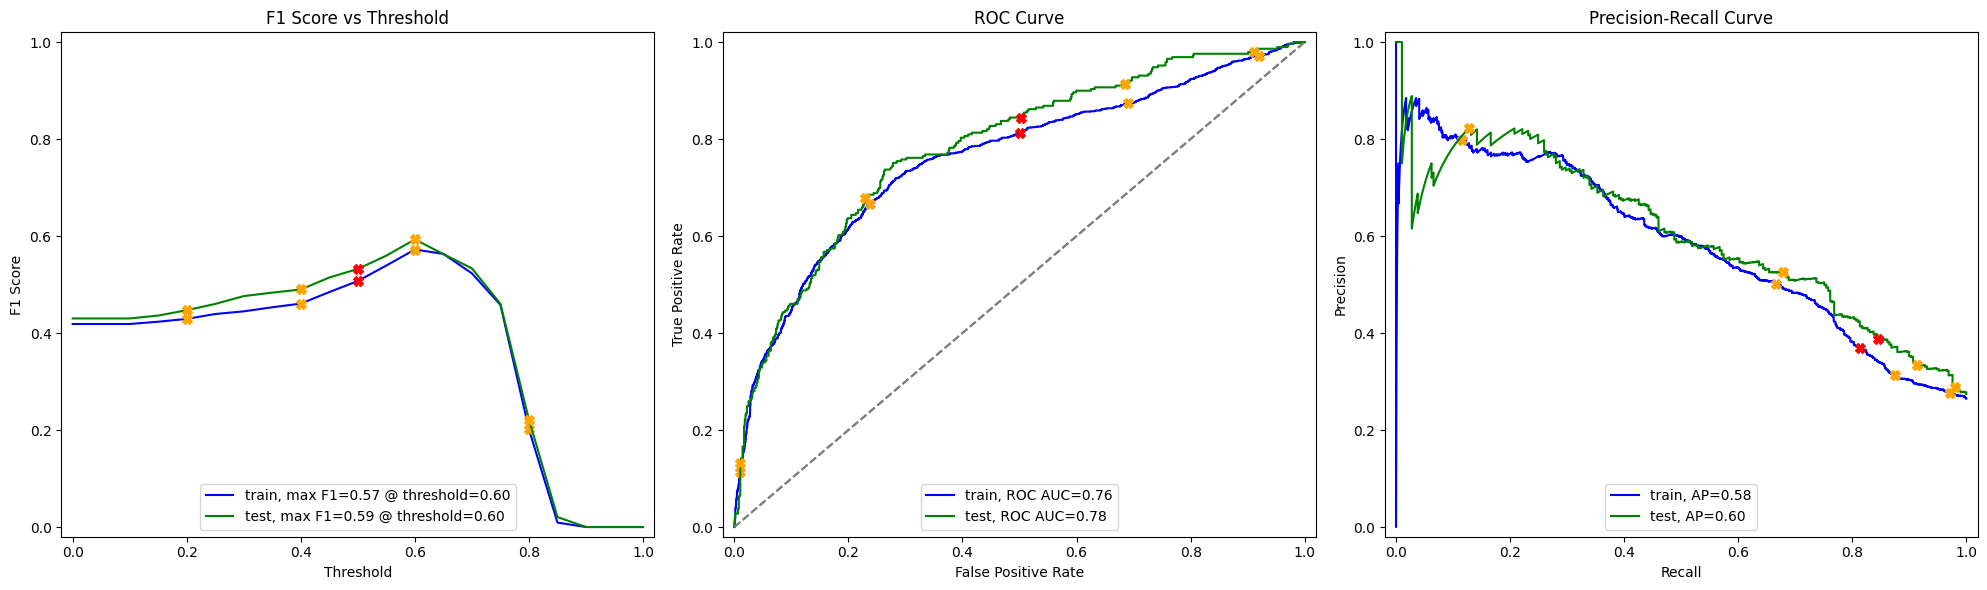

In [81]:
best_lr = LogisticRegression(**best_params, random_state=12345)
best_lr.fit(X_train, y_train)

y_pred_test = best_lr.predict(X_test)
y_proba_test = best_lr.predict_proba(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
lr_auc_test = roc_auc_score(y_test, y_proba_test[:,1])

print("Métricas do LogisticRegression")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em teste: {acc_test}")
print(f"Diferença Treino x Teste: {acc_train - acc_test}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em teste: {lr_auc_test}")
print(f"Diferença Treino x Teste: {auc_train - lr_auc_test}\n")

evaluate_model(best_lr, X_train, y_train, X_test, y_test)


/home/guitolentino/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/guitolentino/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/guitolentino/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/guitolentino/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/guitolentino/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarni

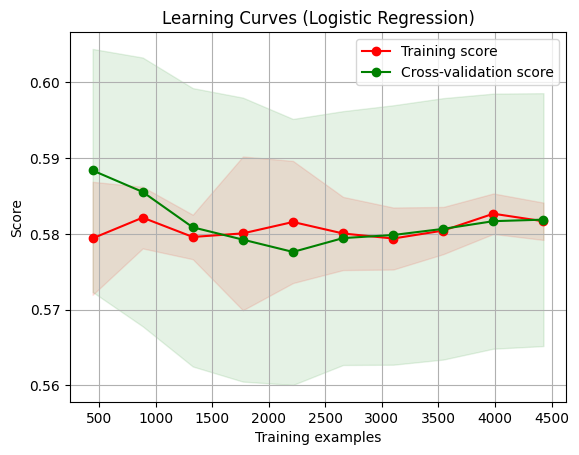

In [82]:

train_sizes, train_scores, test_scores = learning_curve(best_lr, X_train, y_train, cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.show()

## XGBoost

In [83]:
xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100, 
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample= 0.8,
    gamma=0.1,
    scale_pos_weight=9,
    eval_metric='auc',
    random_state=42
)
xgb = Pipeline([
('preprocessor', preprocessor),
('model', xgb)
])

xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCi...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

Métricas do XGBoost
Acurácia
Em treino: 0.7190166598943519
Em validação: 0.6559241706161137
Diferença Treino x Validação: 0.06309248927823818
---------------------------------------------
ROC AUC
Em treino: 0.922588042091316
Em validação: 0.8435728007572876
Diferença Treino x Validação: 0.07901524133402837

          train  test
Accuracy   0.72  0.66
F1 Score   0.73  0.63
APS        0.79  0.65
ROC AUC    0.92  0.84


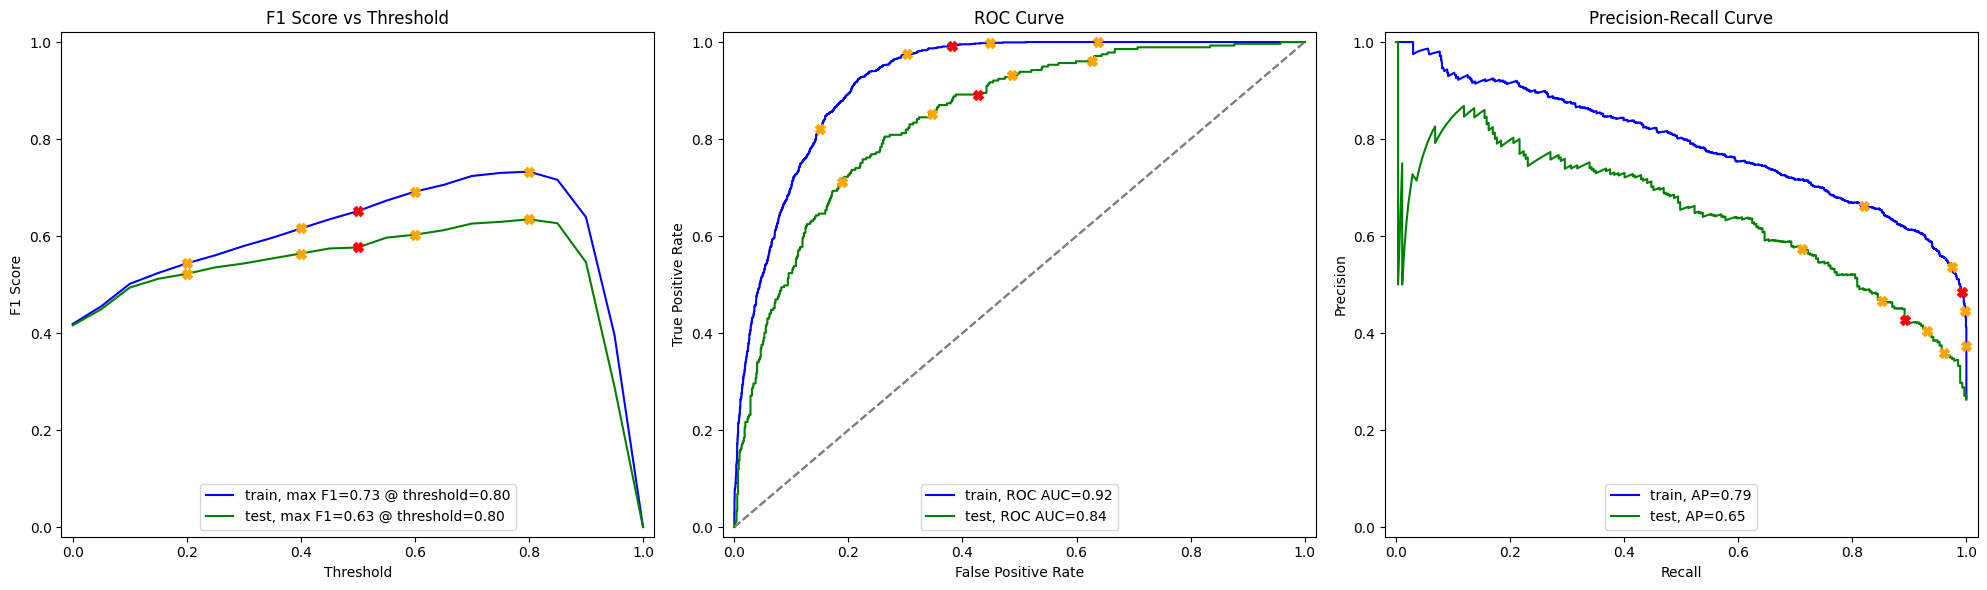

In [84]:
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_val, y_pred_val)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
auc_val = roc_auc_score(y_val, y_proba_val[:,1])

print("Métricas do XGBoost")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em validação: {acc_val}")
print(f"Diferença Treino x Validação: {acc_train - acc_val}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em validação: {auc_val}")
print(f"Diferença Treino x Validação: {auc_train - auc_val}\n")

evaluate_model(xgb, X_train, y_train, X_val, y_val)


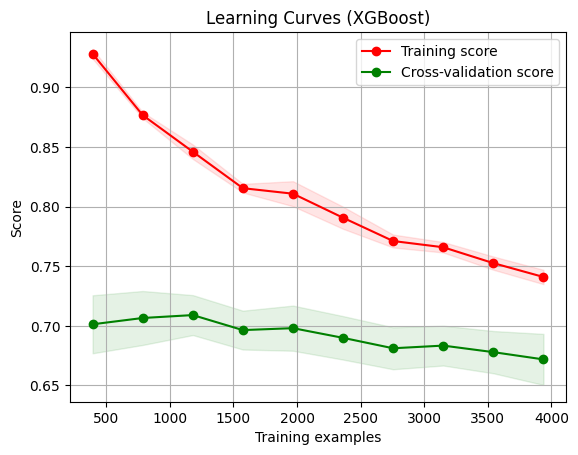

In [87]:
# Plotar Learning Curves

train_sizes, train_scores, val_scores = learning_curve(xgb, X_train, y_train, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure()
plt.title("Learning Curves (XGBoost)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.show()

### Fine tunning de hiperparâmetros com Optuna

In [90]:
# Função de objetivo para o Optuna
def xgb_objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-12, 0.5),  
        'max_depth': trial.suggest_int('max_depth', 2, 15),  
        'subsample': trial.suggest_uniform('subsample', 0.15, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),  
        'gamma': trial.suggest_uniform('gamma', 0, 18),  
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 13),  
        'random_state': 12345  
    }

    model = XGBClassifier(**params)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc

xgb_study = optuna.create_study(study_name='XGBoost', direction='maximize', sampler=TPESampler())
xgb_study.optimize(xgb_objective, n_trials=100, n_jobs=-1)


print("Melhores hiperparâmetros: ", xgb_study.best_params)
print("Melhor ROC AUC: ", xgb_study.best_value)

best_params = xgb_study.best_params

optuna.visualization.plot_optimization_history(xgb_study)
optuna.visualization.plot_param_importances(xgb_study)

[I 2024-10-15 14:42:26,702] A new study created in memory with name: XGBoost
[I 2024-10-15 14:42:27,849] Trial 3 finished with value: 0.8348027433110912 and parameters: {'n_estimators': 63, 'learning_rate': 0.24670787377696524, 'max_depth': 12, 'subsample': 0.9512495923403417, 'colsample_bytree': 0.9237454751625138, 'gamma': 5.507103339690701, 'scale_pos_weight': 6}. Best is trial 3 with value: 0.8348027433110912.
[I 2024-10-15 14:42:28,307] Trial 7 finished with value: 0.8497420025428526 and parameters: {'n_estimators': 54, 'learning_rate': 0.020554652701712948, 'max_depth': 5, 'subsample': 0.6660278534887508, 'colsample_bytree': 0.8895942930788234, 'gamma': 2.7033442583892997, 'scale_pos_weight': 12}. Best is trial 7 with value: 0.8497420025428526.
[I 2024-10-15 14:42:28,834] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 89, 'learning_rate': 1.6369292453302445e-12, 'max_depth': 5, 'subsample': 0.49082110348602304, 'colsample_bytree': 0.257214840151282, 'gamma': 2.

Melhores hiperparâmetros:  {'n_estimators': 184, 'learning_rate': 4.842563207191174e-07, 'max_depth': 9, 'subsample': 0.30472961178536784, 'colsample_bytree': 0.3533258203064672, 'gamma': 17.68611188536707, 'scale_pos_weight': 9}
Melhor ROC AUC:  0.8601732666375879


Métricas do XGBoost
Acurácia
Em treino: 0.7190166598943519
Em teste: 0.2739336492890995
Diferença Treino x Teste: 0.4450830106052524
---------------------------------------------
ROC AUC
Em treino: 0.922588042091316
Em teste: 0.8514843658243515
Diferença Treino x Teste: 0.07110367626696446

          train  test
Accuracy   0.26  0.27
F1 Score   0.42  0.43
APS        0.65  0.67
ROC AUC    0.85  0.85


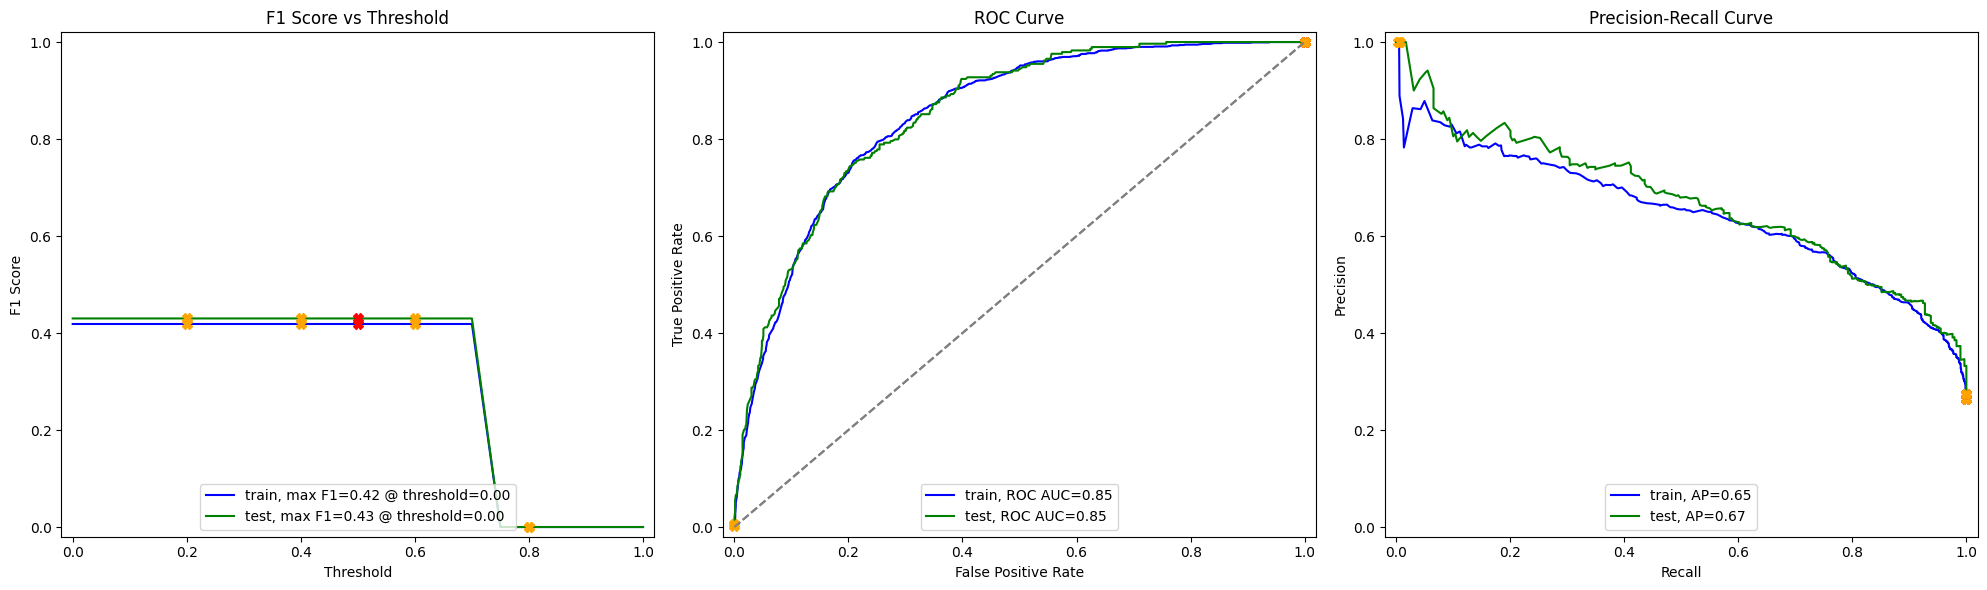

In [91]:
best_xgb = XGBClassifier(**best_params, random_state=12345)
best_xgb.fit(X_train, y_train)

y_pred_test = best_xgb.predict(X_test)
y_proba_test = best_xgb.predict_proba(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
auc_train = roc_auc_score(y_train, y_proba_train[:,1])
xgb_auc_test = roc_auc_score(y_test, y_proba_test[:,1])

print("Métricas do XGBoost")
print("=" * 45)
print("Acurácia")
print(f"Em treino: {acc_train}")
print(f"Em teste: {acc_test}")
print(f"Diferença Treino x Teste: {acc_train - acc_test}")
print("-" * 45)
print("ROC AUC")
print(f"Em treino: {auc_train}")
print(f"Em teste: {xgb_auc_test}")
print(f"Diferença Treino x Teste: {auc_train - xgb_auc_test}\n")

evaluate_model(best_xgb, X_train, y_train, X_test, y_test)

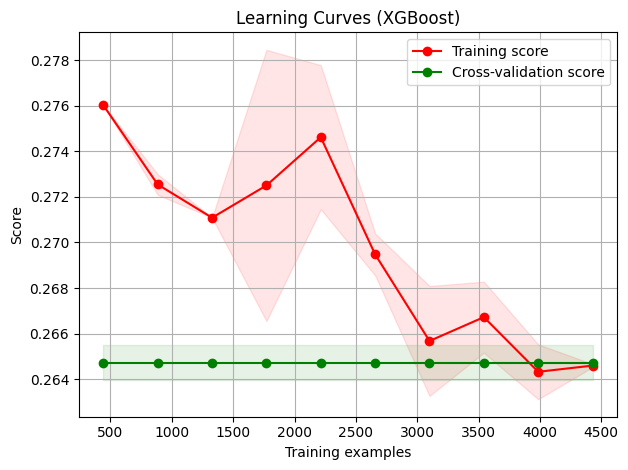

In [92]:
train_sizes, train_scores, test_scores = learning_curve(best_xgb, X_train, y_train, cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves (XGBoost)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

## Melhores parâmetros

In [93]:
# Melhores parametros para o conjunto de validação
print(f'Melhores resultados obtidos com o conjunto de validação:\n')
RandomForestClassifier = print(f'RandomForestClassifier best AUC: {rf_study.best_value:.2f}')
SVC = print(f'SVC best AUC: {svc_study.best_value:.2f}')
LogisticRegression = print(f'LogisticRegression best AUC: {lr_study.best_value:.2f}')
XGBoost = print(f'XGBoost best AUC: {xgb_study.best_value:.2f}')

Melhores resultados obtidos com o conjunto de validação:

RandomForestClassifier best AUC: 0.86
SVC best AUC: 0.84
LogisticRegression best AUC: 0.85
XGBoost best AUC: 0.86


In [94]:
# Melhores parametros para o conjunto de teste

print(f'Melhores resultados obtidos com o conjunto de teste:\n')
RandomForestClassifier = print(f'RandomForestClassifier best AUC: {rf_auc_test:.2f}')
SVC = print(f'SVC best AUC: {svc_auc_test:.2f}')
LogisticRegression = print(f'LogisticRegression best AUC: {lr_auc_test:.2f}')
XGBoost = print(f'XGBoost best AUC: {xgb_auc_test:.2f}')


Melhores resultados obtidos com o conjunto de teste:

RandomForestClassifier best AUC: 0.85
SVC best AUC: 0.83
LogisticRegression best AUC: 0.78
XGBoost best AUC: 0.85


Os melhor modelo, após o fine tunning, foi o XGBoost. 
O RandomForestClassifier foi o segundo melhor modelo, empatando com o XGBoost após o arredodamento do resultado.
Para melhorar ainda mais os resultados, será necessário realizar mais feature engeneering.

# Conclusões

Na elaboração do projeto, todos os passos solicitados foram executados.

Primeiramente, foram carregados os quatro dataframes e realizada uma análise acerca da qualidade dos dados, como verificação de dados nulos, duplicados e tipos de dados.

Para viabilizar a análise final sobre o Churn, foi necessário criar uma coluna alvo cujo valor se deu pela diferença entre as colunas BeginDate e EndDate, e também uma de duração dos contratos. 

Em seguida, passou-se à análise exploratória dos dados, composta por duas etapas: análise de variáveis categóricas e análise de variáveis numéricas.

As variáveis categóricas foram confrontadas com o Churn, de maneira a verificar a existência de correlação entre elas, o que resultou nas conclusões apresentadas neste notebook.

As variáveis numéricas também foram confrontadas com o Churn para verificar qual seu impacto sobre a ocorrência deste. A análise também gerou conclusões que se encontrar ao final da referida seção.

Na segunda parte do trabalho, os dados foram preparados para serem utilizados nos modelos de machine learning. Para isso, foi elaborado um dataframe final, composto pela união dos quatro dataframes iniciais, e excluindo as colunas que não contribuiriam para os resultados.

Para garantir que os valores da coluna Churn estava corretos, foi feito um .map determinando que ‘0’ corresponderia a  ‘No’ , e  ‘1’ a ‘Yes’.

Prosseguindo com o pré-processamento, as variáveis categóricas foram separas e transformadas em numéricas utilizando o OrdinalEncoder.

Definimos, também, uma função de avaliação de modelos para ser utilizada em outros momentos no notebook.

Os dados foram separados em conjuntos de treino (70%), validação (15%) e teste (15%).

Os modelos escolhidos foram RandomForestClassifier, SupportVectorClassifier, LogisticRegression e XGBoost.

Em um primeiro momento, os resultados estavam próximos de 1 para todos os modelos, tanto em treino quanto em teste e, após conversa com o Tutor, foi identificado vazamento de dados.

Para solucioná-lo, a coluna com o tempo de duração dos contratos foi excluída e o problema solucionado.

Todos os modelos foram, então, seguiram o mesmo processo:
- Treinamento com o conjunto de treino;
- Avaliação com o conjunto de validação e plotagem de gráficos de desempenho e curvas de aprendizado;
- Ajuste de hiperparâmetros, utilizando o conjunto de validação e por meio de estudos do Optuna;
- Teste final com o conjunto testes.

Por fim, após percorrer as principais etapas do projeto: carregamento e verificação dos dados, análise exploratória dos dados, pré-processamento, seleção e treinamento de modelos, concluímos que o melhor desempenho foi obtido com o XGBoost. As diferenças foram pequenas, mas o modelo performou ligeiramente melhor que os outros.

Resultado final:
- Modelo escolhido: XGBoostClassifier
- AUC para conjunto de validação: 0.86
- AUC para o conjunto de testes: 0.85






# Análise do melhor modelo: XGBoostClassifier

Acurácia do modelo: 0.27
AUC do modelo: 0.85
Matriz de Confusão:
           Predição Não Churn  Predição Churn
Não Churn                   0             766
Churn                       0             289


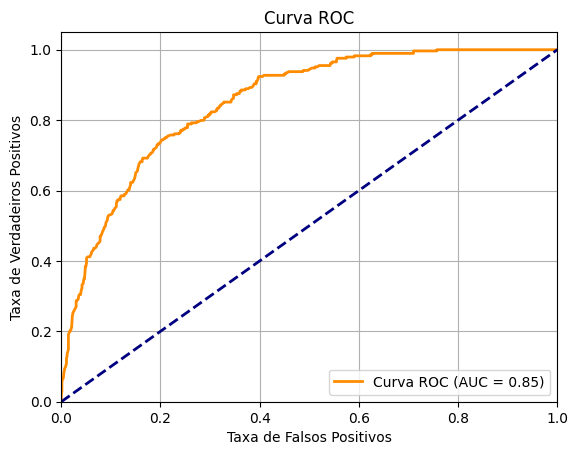

In [111]:
model = best_xgb

model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba[:,1])
print(f'Acurácia do modelo: {acc:.2f}')
print(f'AUC do modelo: {auc:.2f}')

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(conf_matrix, index=['Não Churn', 'Churn'], columns=['Predição Não Churn', 'Predição Churn'])
print(f'Matriz de Confusão:\n{conf_matrix}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


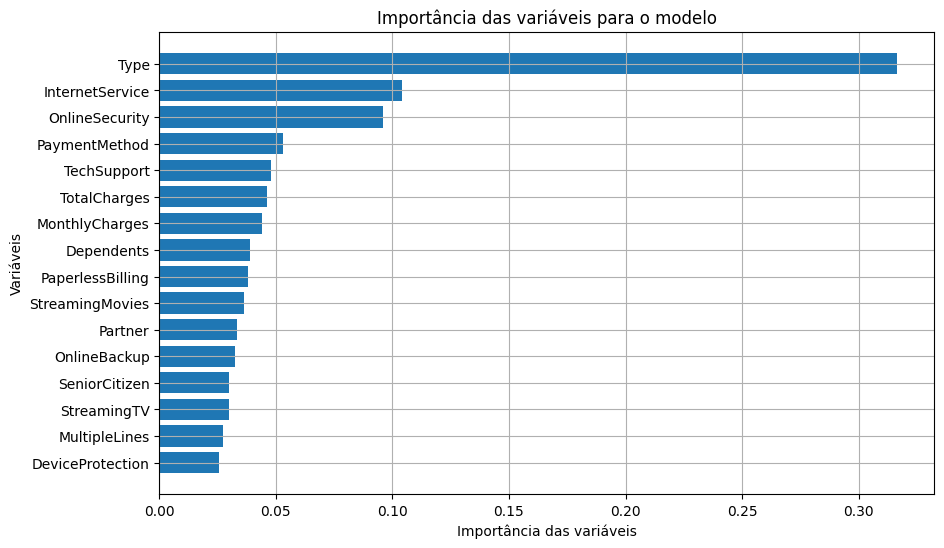

In [96]:
indexes = np.argsort(model.feature_importances_)[::1]
coef = model.feature_importances_[indexes]

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[indexes], coef, align='center')
plt.xlabel('Importância das variáveis')
plt.ylabel('Variáveis')
plt.title('Importância das variáveis para o modelo')
plt.grid()
plt.show()


Acurácia média: 0.27
Intervalo de Confiança (95%): [0.27, 0.27]


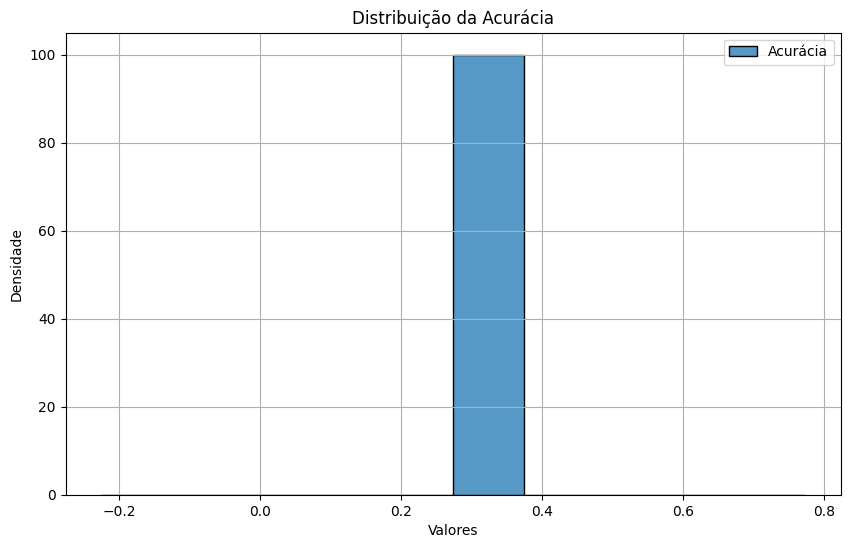

In [104]:
def bootstrap_accuracy(model, X_train, y_train, n_iterations=10):
    n_size = len(X_train)
    scores = []

    for _ in range(n_iterations):
        indices = np.random.choice(range(n_size), size=n_size, replace=True)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]

        model.fit(X_sample, y_sample)

        y_scores = model.predict(X_test)
        score = accuracy_score(y_test, y_scores)
        scores.append(score)
        

    return np.array(scores)

n_iterations = 10
scores = bootstrap_accuracy(model, X_train, y_train, n_iterations)

lower_bound = np.percentile(scores, 2.5)
upper_bound = np.percentile(scores, 97.5)

print(f'Acurácia média: {scores.mean():.2f}')
print(f'Intervalo de Confiança (95%): [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.figure(figsize=(10, 6))
sns.histplot(x= scores, label='Acurácia', bins=10)
plt.title('Distribuição da Acurácia')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.grid()
plt.legend()
plt.show()



AUC média: 0.85
Intervalo de Confiança (95%): [0.85, 0.85]


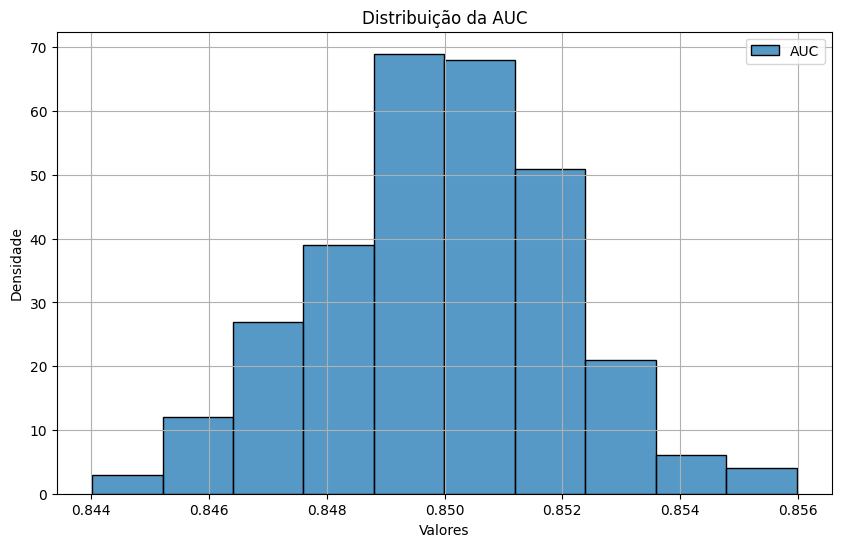

In [123]:
def bootstrap_auc(model, X_train, y_train, X_test, y_test, n_iterations=300):
    n_size = len(X_train)
    auc_scores = []

    for _ in range(n_iterations):
        indices = np.random.choice(range(n_size), size=n_size, replace=True)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]

        model.fit(X_sample, y_sample)

        y_scores = model.predict_proba(X_test)[:, 1]  
        score = roc_auc_score(y_test, y_scores)
        auc_scores.append(score)

    return np.array(auc_scores)

n_iterations = 300
auc_scores = bootstrap_auc(model, X_train, y_train, X_test, y_test, n_iterations)

lower_bound = np.percentile(auc_scores, 2.5)
upper_bound = np.percentile(auc_scores, 97.5)

print(f'AUC média: {auc_scores.mean():.2f}')
print(f'Intervalo de Confiança (95%): [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.figure(figsize=(10, 6))
sns.histplot(x= auc_scores, label='AUC', bins=10)
plt.title('Distribuição da AUC')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.grid()
plt.legend()
plt.show()


Por fim, analisamos o modelo escolhido.

As variáveis que possuem maior peso para o modelo são a periodicidade de cobrança escolhida, o tipo de serviço de internet, se o usuário utiliza ou não os serviços de proteção online, e a forma de pagamento.

As demais colunas possuem pesos menores.

Fizemos nova avaliação de acurácia e auc utilizando a técnica do bootstraping e os resultados foram os seguintes:
- Accuracy: 0.27. O número de iterações escolhido foi menor porque não estava influenciando no resultado, então a redução visou poupar tempo e processamento.
- AUC: 0.85, com intervalo de confiança de 95%.

Verifica-se, portanto, que o modelo performa bem em identificar classes positivas e negativas. Nesse caso, em específico, temos um Target bastante desbalanceado, o que reforça a eficiência do modelo, já que ele trabalha com diferentes thresholds.

Concluímos que o modelo atingiu um resultado bastante satisfatório e que conseguirá atender as necessidades do cliente.
